<center>
<img src="https://raw.githubusercontent.com/FUlyankin/ekenam_grand_research/master/images/cover.png">
</center>


# <center> Иканам гранд рисёрч </center>
## <center>  Часть четвёртая: моделирование. Предобработка данных </center>


Проект **Иканам гранд рисёрч** реализуется [Иканам стьюдентс коммьюнити,](https://vk.com/ikanam)
в частности [вот этим парнем по имени Филипп.](https://vk.com/ppilif)  Если вы нашли ошибку или у вас есть предложения, замечания, деньги, слава или женщины, можно ему написать. Весь говнокод, использованный в исследовании распостраняется по лицензии [Creative Commons CC BY-NC-SA 4.0.](https://creativecommons.org/licenses/by-nc-sa/4.0/) Его можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала. При наличии технической возможности необходимо также указать активную гиперссылку на [страницу рисёрча.](https://github.com/FUlyankin/ekenam_grand_research) 

In [1]:
import warnings     # Игнорирование варнингов
warnings.filterwarnings("ignore")  

In [2]:
import numpy as np     # Нумпай для векторов 
import pandas as pd    # Пандас для табличек 
# Округлять в табличках значения до второго знака
pd.set_option('precision', 2)           

# Пакеты для графииков
import matplotlib.pyplot as plt                             
import seaborn as sns
plt.style.use('ggplot')   # Правильный стиль графиков   

# Пакет для красивых циклов. При желании его можно отключить. Тогда из всех циклов придётся 
# удалять команду tqdm_notebook.
from tqdm import tqdm_notebook   # подробнее: https://github.com/tqdm/tqdm

In [3]:
%matplotlib inline  

И для начала несколько определений. **Фича** - регрессор, признак, объясняющая переменная, на которую мы можем посмотреть. **Таргет** - объясняемая переменная, переменная, которую нужно спрогнозировать. **Варить фичи** - создавать из грязного массива данных годные числовые переменные, которые можно запихнуть в модель. 

# 1. Агрегируем данные асессоров и варим таргеты 


В нашем распоряжении есть довольно много табличек с разным содержимым. Всё это содержимое надо как следует переварить. Начнём мы процесс переваривания с коллекции табличек под названием  `Total_razm`. 

`Total_razm` это набор из 6 табличек по данным о наборах с 2012 по 2017 год. Внутри находятся данные о ЕГЭ, условиях поступления, отметка на каком курсе учится человек, а также с какого курса его отчислили. Кроме того, проставлены две субъективные переменные, отражающие степень того как часто человек ходит на пары и как часто зажигает на вечеринках. Напомню, что каждую разметку проставляли независимо друг от друга несколько разных групп людей. Отдельно отметим, что данные по людям, взятым на учёбу в 2017 году, мы будем использовать для прогнозирования отчислений. 

## 1.1 Варим табличку

Подгружаем всё это добро в нашу тетрадку. 

In [4]:
# файлы, в которых лежат id и другие размеченые данные называются Total_20XX 
# Заведем вектор со всеми годами, которые есть у нас в распоряжении
file_names = ['2012','2013','2014','2015','2016','2017']
tables = [ ] # Вектор, куда мы будем записывать все уиды  (user id)

# Проходимся по всем файлам и подгружаем их
for file in file_names: 
    cur_df = pd.read_excel('Total_razmetka/Total_' + file + '.xlsx') # В этой папке файлы...
    tables.append(cur_df)

Посмотрим на одну из табличек. 

In [5]:
tables[3].head()

kurs_1  kurs_2  kurs_3 Leto-zima_1 Leto-zima_2 Leto-zima_3  Akadem_1  \
0       1     1.0     1.0        leto         NaN        leto       NaN   
1       3     3.0     3.0         NaN         NaN         NaN       NaN   
2       3     3.0     3.0         NaN         NaN         NaN       NaN   
3       1     1.0     NaN        zima        zima         NaN       NaN   
4       3     3.0     3.0         NaN         NaN         NaN       NaN   

   Akadem_2  Akadem_3  hodit_para_1    ...     tusovka_3  EGE  dogovor  \
0       NaN       NaN             2    ...           1.0  307        0   
1       NaN       NaN             4    ...           3.0  238        0   
2       NaN       NaN             2    ...           2.0  269        0   
3       NaN       NaN             2    ...           NaN  254        0   
4       NaN       NaN             5    ...           1.0  247        0   

   Ochko-zaochka  olimp  chelevoe  lgota  prohodnoy  year      uids  
0              0      1         0      0        253  2015  1.20e+08  
1              0      1         0      0        253  2015  8.53e+07  
2              0      1         0      0        253  2015  3.77e+07  
3              0      0         1      0        253  2015  1.40e+08  
4              0      0         1      0        253  2015  8.66e+07  

[5 rows x 24 columns]

In [6]:
tables[3].columns

Index(['kurs_1', 'kurs_2', 'kurs_3', 'Leto-zima_1', 'Leto-zima_2',
       'Leto-zima_3', 'Akadem_1', 'Akadem_2', 'Akadem_3', 'hodit_para_1',
       'hodit_para_2', 'hodit_para_3', 'tusovka_1', 'tusovka_2', 'tusovka_3',
       'EGE', 'dogovor', 'Ochko-zaochka', 'olimp', 'chelevoe', 'lgota',
       'prohodnoy', 'year', 'uids'],
      dtype='object')

Отлично! Берём нашу табличку и руководствуясь мудростью толпы начинаем усреднять ответы асессоров. Где-то мы будем брать медиану, где-то среднее. 

In [9]:
def table_creator(ddf):
    df = ddf.copy()
    ok_col = ['uids', 'year', 'EGE', 'prohodnoy',
     'lgota', 'chelevoe', 'olimp', 'dogovor']

    dff = df[ok_col]
    if 'Ochko-zaochka' in df.columns:
        dff['ochko-zaochka'] = df['Ochko-zaochka']
    else:
        dff['ochko-zaochka'] = [0]*df.shape[0]

    df.drop(ok_col, axis = 1, inplace=True)
    
    # Заполняем колонку курс медианой. 
    dff['kurs'] = np.nanmedian(df[[name for name in \
                            df.columns if name[:5] == 'kurs_']].get_values(), axis=1).astype(int)

    # Заполняем колонку из сессий, будем выбирать максимальную из предложенных оценок
    seazon = df[[name for name in df.columns if name[:5] == 'Leto-']].fillna(0)\
                                 .replace({'leto':1,'zima':2}).max(axis=1)
        
    dff['zima'] = [1 if z == 2 else 0 for z in seazon]
    dff['leto'] = [1 if z == 1 else 0 for z in seazon]

    # Если хотя бы раз пацаны подумали, что человек пытался вернуться (академ или восстановление), 
    # то поставим единичку 
    ak = df[[name for name in df.columns if name[:5] == 'Akade']].fillna(0).sum(axis=1)
    dff['akadem'] = [int(item > 0) for item in ak] 

    # Оценку хождения на пары и на тусовки усредним
    dff['hodit_para'] = np.nanmean(df[[name for name in df.columns if name[:5] == 'hodit']],axis=1)

    # Я тупанул и попросил часть людей ставить оценку по 3-бальной шкале, 
    # часть людей я попросил ставить оценку по 5-бальной шкале
    maxes = np.nanmax(df[[name for name in df.columns if name[:5] == 'tusov']],axis=0)
    # Поэтому сначала перенормируем, потом усредним
    dff['hodit_tusa'] = np.nanmean(df[[name for name in df.columns if name[:5] == 'tusov']]\
                                     .ix[:,maxes == 3]*5/3, axis=1)
    # исправляем косяки:
    dff['chelevoe'].fillna(0,inplace=True) # В какой-то из таблиц забыли проставить нули
    return dff

In [19]:
test_df = table_creator(tables[0])
test_df.head(10)

uids  year  EGE  prohodnoy  lgota  chelevoe  olimp  dogovor  \
0  1.18e+07  2012  203        247      0         0      1        0   
1  2.03e+07  2012  255        247      0         0      1        0   
2  1.55e+08  2012  249        247      0         0      1        0   
3  1.35e+08  2012  242        247      1         0      0        0   
4  1.04e+08  2012  203        247      1         0      0        0   
5  2.57e+07  2012  194        247      1         0      0        0   
6  1.49e+08  2012  179        247      1         0      0        0   
7  2.17e+08  2012  219        247      1         0      0        0   
8  8.25e+07  2012  276        247      0         0      0        0   
9  1.49e+08  2012  274        247      0         0      0        0   

   ochko-zaochka  kurs  zima  leto  akadem  hodit_para  hodit_tusa  
0              0     5     0     0       0        2.67        3.33  
1              0     5     0     0       0        3.67        3.33  
2              0     5     0     0       0        3.67        3.33  
3              0     1     0     1       0        3.33        1.67  
4              0     2     1     0       1        3.67        1.67  
5              0     2     1     0       1        2.67        1.67  
6              0     2     0     1       0        1.33        1.67  
7              0     1     1     0       0        1.67        1.67  
8              0     3     0     1       1        2.00        3.33  
9              0     1     0     1       0        3.33        1.67

In [11]:
total_df = table_creator(tables[0])

for tbl in tables[1:]:
    total_df = total_df.append(table_creator(tbl))

# Заполняем новый, 2017 год нанами.
total_df.ix[total_df.year == 2017,'kurs'] = None

print(total_df.shape)
total_df.head()

(460, 15)


uids  year    EGE  prohodnoy  lgota  chelevoe  olimp  dogovor  \
0  1.18e+07  2012  203.0        247      0       0.0      1        0   
1  2.03e+07  2012  255.0        247      0       0.0      1        0   
2  1.55e+08  2012  249.0        247      0       0.0      1        0   
3  1.35e+08  2012  242.0        247      1       0.0      0        0   
4  1.04e+08  2012  203.0        247      1       0.0      0        0   

   ochko-zaochka  kurs  zima  leto  akadem  hodit_para  hodit_tusa  
0              0   5.0     0     0       0        2.67        3.33  
1              0   5.0     0     0       0        3.67        3.33  
2              0   5.0     0     0       0        3.67        3.33  
3              0   1.0     0     1       0        3.33        1.67  
4              0   2.0     1     0       1        3.67        1.67

Посмотрим на размеры таблички и количество пропусков. 

In [12]:
print(total_df.shape)
total_df.isnull().sum()

(460, 15)


uids              22
year               0
EGE                8
prohodnoy          0
lgota              0
chelevoe           0
olimp              0
dogovor            0
ochko-zaochka      0
kurs              79
zima               0
leto               0
akadem             0
hodit_para        44
hodit_tusa       107
dtype: int64

Доводим нашу таблицу до ума. 

* Каждый год разный проходной балл. Построим переменную, которая будет выглядть как балл - проходной балл
* Введём дамми-переменную с незамысловатым наименованием `kozko` (поймут не все)
* Построим несколько таргетов `target_i = 1`, если человек закончил курс i, при условии что он закончил предыдущие

In [13]:
# Строим переменные 
total_df.dropna(subset=['EGE'], inplace=True)
total_df['ege_diff'] = total_df['EGE'] - total_df['prohodnoy']
total_df['kozko'] = (total_df.year == 2013)|(total_df.year == 2015)|(total_df.year == 2017)
total_df['kozko'] = total_df['kozko'].astype(int)

# Строим таргеты 
# человек закончил 1 курс 
# 1 - закончил 1 курс, 0 - нет, na - неизвестно
total_df['target_1'] = 1*(total_df.kurs > 1).astype(int)
total_df.ix[total_df.year == 2017,'target_1'] = None

# человек закончил 2 курс, при условии, что он закончил 1 
# 1 - закончил 2 курс, при условии что закончил 1, 0 - нет, na - неизвестно
# na - не поступил на 2 курс, чтобы его закончить... 
total_df['target_2'] = 1*((total_df.target_1 == 1)&(total_df.kurs > 2)).astype(int)
total_df.ix[(total_df.year > 2015)|(total_df.target_1 == 0), 'target_2'] = None

# человек закончил 3 курс, при условии, что он закончил 2
# 1 - закончил 3 курс, при условии что закончил 2, 0 - нет, na - неизвестно
total_df['target_3'] = 1*((total_df.target_2 == 1)&(total_df.kurs > 3))
total_df.ix[(total_df.year > 2014)|(total_df.target_2 == 0)|(total_df.target_1 == 0), 'target_3'] = None

# человек закончил 4 курс, при условии, что он закончил 3
# 1 - закончил 4 курс, при условии что закончил 3, 0 - нет, na - неизвестно
total_df['target_4'] = 1*((total_df.target_3 == 1)&(total_df.kurs > 4)).astype(int)
total_df.ix[(total_df.year > 2013)|\
         (total_df.target_3 == 0)|(total_df.target_2 == 0)|(total_df.target_1 == 0),'target_4'] = None


In [14]:
total_df.head()

uids  year    EGE  prohodnoy  lgota  chelevoe  olimp  dogovor  \
0  1.18e+07  2012  203.0        247      0       0.0      1        0   
1  2.03e+07  2012  255.0        247      0       0.0      1        0   
2  1.55e+08  2012  249.0        247      0       0.0      1        0   
3  1.35e+08  2012  242.0        247      1       0.0      0        0   
4  1.04e+08  2012  203.0        247      1       0.0      0        0   

   ochko-zaochka  kurs    ...     leto  akadem  hodit_para  hodit_tusa  \
0              0   5.0    ...        0       0        2.67        3.33   
1              0   5.0    ...        0       0        3.67        3.33   
2              0   5.0    ...        0       0        3.67        3.33   
3              0   1.0    ...        1       0        3.33        1.67   
4              0   2.0    ...        0       1        3.67        1.67   

   ege_diff  kozko  target_1  target_2  target_3  target_4  
0     -44.0      0       1.0       1.0       1.0       1.0  
1       8.0      0       1.0       1.0       1.0       1.0  
2       2.0      0       1.0       1.0       1.0       1.0  
3      -5.0      0       0.0       NaN       NaN       NaN  
4     -44.0      0       1.0       0.0       NaN       NaN  

[5 rows x 21 columns]

Посмотрим на пропуски в данных.

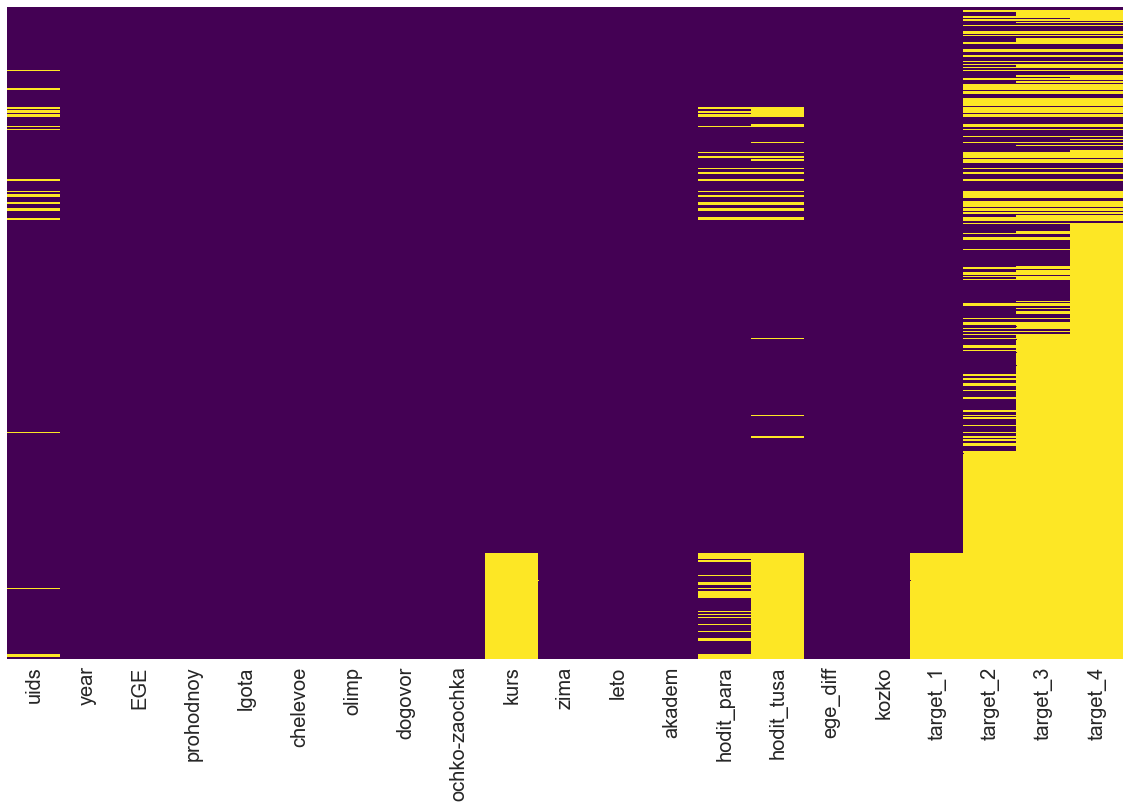

In [15]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(total_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Посмотрим на распределения таргетов. 

target_1  target_2  target_3  target_4
1       258       185       115        67
0       121        23        10         4

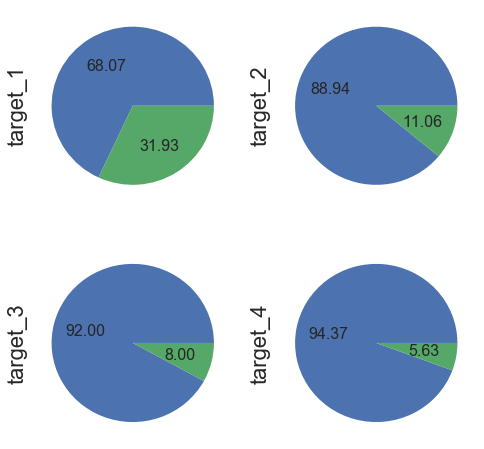

In [16]:
plt.figure(figsize=(30,30))
plt.subplot(2,2,1)
total_df.target_1.value_counts().plot.pie(autopct='%.2f', fontsize=16, figsize=(8, 8),labels=None)
plt.subplot(2,2,2)
total_df.target_2.value_counts().plot.pie(autopct='%.2f', fontsize=16, figsize=(8, 8),labels=None)
plt.subplot(2,2,3)
total_df.target_3.value_counts().plot.pie(autopct='%.2f', fontsize=16, figsize=(8, 8),labels=None)
plt.subplot(2,2,4)
total_df.target_4.value_counts().plot.pie(autopct='%.2f', fontsize=16, figsize=(8, 8),labels=None)

pd.DataFrame([total_df.target_1.value_counts().get_values(),total_df.target_2.value_counts().get_values(),
              total_df.target_3.value_counts().get_values(),total_df.target_4.value_counts().get_values()],
            index = ['target_1','target_2','target_3','target_4'], columns = ['1','0']).T


Строить модель, которая будет прогнозировать отчисления с первого курса будет легко и весело. У нас довольно много как положительных, так и отрицательных примеров. С прогнозированием отчисление со второго, третьего и четвёртого курса, у нас будет довольно много проблем. Модель мы будем строить по 379 наблдюдениям. 

In [17]:
sum(total_df.year != 2017)

379

Прогнозы мы будем строить для 73 первокурсников. 

In [17]:
sum(total_df.year == 2017)

73

Сохраняем первый, самый простой датасет. 

In [18]:
!pwd

/Users/fulyankin/Documents/ekanam_grand_research/4. Data prepare_and_Models


In [19]:
total_df.to_csv('data1_simple.csv', sep = '\t')

In [20]:
!ls

5. data_prepare.ipynb          data_all_prof.csv
6.1 Models.ipynb               data_all_wl.csv
6.2 models_hypotesis_R.ipynb   readme
Total_razmetka                 simple_data.csv
data1_simple.csv               test_data_for_R.csv
data2_prof.csv                 train_data_for_R.csv
data3_prof_ph.csv              variables.csv
data4_prof_ph_wl.csv           vk_publ_clust_20_v11-01-18.csv
data5_prof_ph_wl_pub.csv       vk_publ_clust_30_v11-01-18.csv
data_all_photo.csv


In [21]:
total_df.shape

(452, 23)

## 1.2 Проверяем гипотезу десятилетия 

Во-первых, заметим, что люля людей, которые заканчивают первый курс равна примерно $2/3$.  

In [22]:
stat = total_df.target_1.value_counts()
stat[1]/(stat[0] + stat[1])

0.68073878627968343

Ахмед, Лёша. Добро пожаловать в этот раздел. Сейчас я собираюсь уничтожить всё, что вам действительно дорого. Пришло время развеять один очень важный миф, который поселился среди студентов иканама:  

> Когда матан читает Козко, с первого курса отчисляют больше людей. 

Сформулируем гипотезу. 

$H_0\colon$ в среднем людей отчисляют одинаково, $p_{k} = p_{ch}$

$H_1\colon$ ничего подобного, $p_{k} \ne p_{ch}$

Для проверки гипотезы возьмём 2012, 2013, 2014 и 2015 года. 

In [23]:
kozko_df = total_df.dropna(subset=['target_1'])
x_kozko = 1 -kozko_df[(kozko_df.kozko == 1)&(kozko_df.year != 2016)].target_1
x_nekozko = 1 - kozko_df[(kozko_df.kozko == 0)&(kozko_df.year != 2016)].target_1

print('Вероятность не закончить 1 курс при Козко:',   sum(x_kozko)/len(x_kozko))
print('Вероятность не закончить 1 курс при Чирском:', sum(x_nekozko)/len(x_nekozko))

Вероятность не закончить 1 курс при Козко: 0.3496932515337423
Вероятность не закончить 1 курс при Чирском: 0.296551724137931


Чтобы всё было максимально прозрачно, напишем свою функцию для проверки гипотезы, руководствуясь лекциями Палыча.

In [24]:
import scipy

def proportions_diff_z_stat_ind(sample1, sample2):
    '''
    Функция, написанная по лекциям Палыча
    
    '''
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    '''
    функция для расчта p-value при разных альтернативах
    
    '''
    
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

Мы готовы к проверке. 

In [25]:
proportions_diff_z_test(proportions_diff_z_stat_ind(x_kozko, x_nekozko))

0.32014582359010602

Альтернатива должна быть $p_k > p_{ch}$? Окей. 

In [26]:
proportions_diff_z_test(proportions_diff_z_stat_ind(x_kozko, x_nekozko),'greater')

0.16007291179505301

Результат не поменялся. Гипотеза о равенстве долей не отвергается. Можно попробовать не выкидывать "лишний год" и проверять гипотезу на 3-х годах Чирского и двух годах Козко. 

In [27]:
kozko_df = total_df.dropna(subset=['target_1'])
x_kozko = 1 -kozko_df[(kozko_df.kozko == 1)].target_1
x_nekozko = 1 - kozko_df[(kozko_df.kozko == 0)].target_1

print('Вероятность не закончить 1 курс при Козко:',   sum(x_kozko)/len(x_kozko))
print('Вероятность не закончить 1 курс при Чирском:', sum(x_nekozko)/len(x_nekozko))

proportions_diff_z_test(proportions_diff_z_stat_ind(x_kozko, x_nekozko))

Вероятность не закончить 1 курс при Козко: 0.3496932515337423
Вероятность не закончить 1 курс при Чирском: 0.2962962962962963


0.26960949655974931

Напомню, что в других преподах между двумя первыми курсами различий нет. Мораль всего этого проста: __Если ты тупой, неважно кто читает у тебя матан.__  Скорее всего, вы мне предложите дождаться результатов по отчислениям за этот год, а после перепроверить гипотезу. Друзья, я в курсе, что вы ходите принимать колки по матану. Неужели вы способны для того, чтобы доказать свою точку зрения поставить лишние двойки? 

Посмотрим на матрицу корреляций для нашей таблички. 

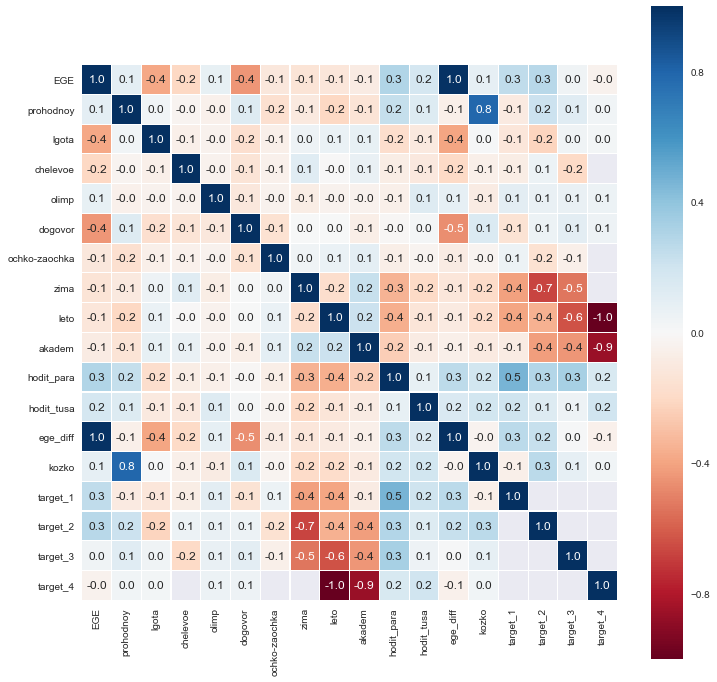

In [28]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(total_df.drop(['year','uids','kurs'],axis=1).corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Вопрос на засыпку для читателя: почему некоторые области остались серыми и правильно ли это. 

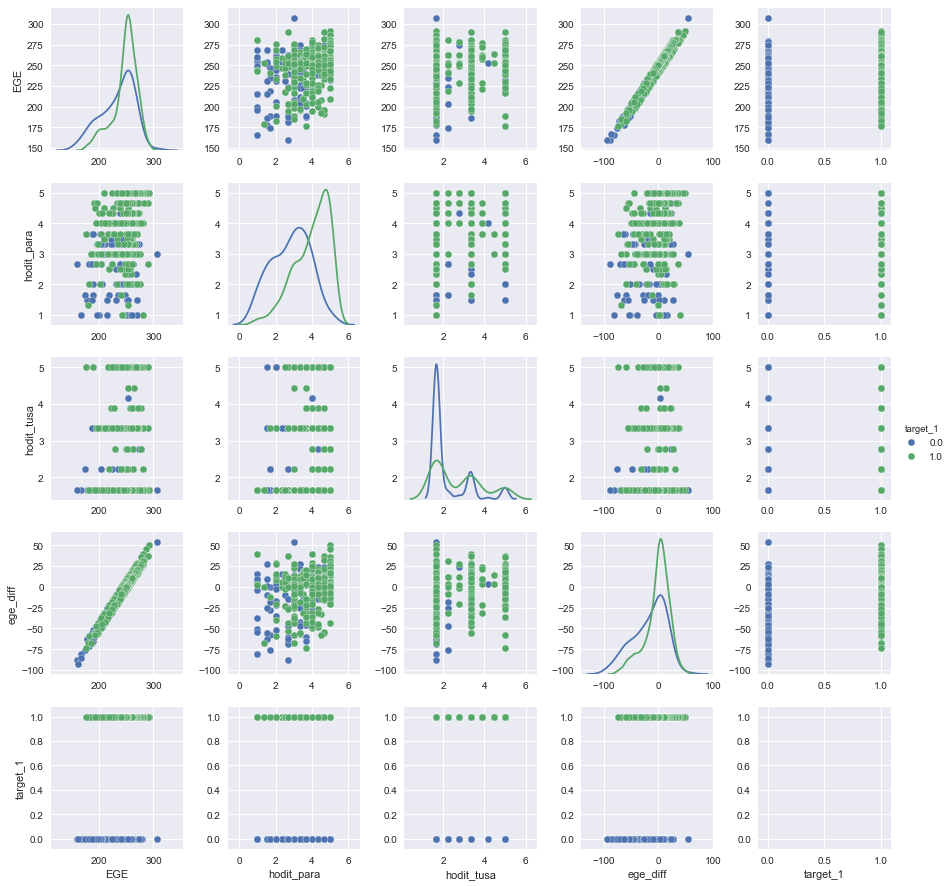

In [29]:
regr = ['EGE', 'hodit_para', 'hodit_tusa', 'ege_diff', 'target_1']
sns.pairplot(total_df[regr], hue = 'target_1', diag_kind="kde")

Видим, что баллы за ЕГЭ не в среднем никак не говорят об отчисляемости. При этом те, кого отчисляют, судя по всему, в среднем ходят на пары реже. Не будем забывать, что показатель, отвечающий за хождение на пары, проставляли асессоры. Они могли ставить более низкие оценки тем ребятам, которых отчислили чисто психологически. 

На последок посмотрим сколько людей отчислили летом, а сколько зимой. 

In [30]:
print('Отчислили летом:',   sum(total_df.leto))
print('Отчислили зимой:', sum(total_df.zima))

Отчислили летом: 69
Отчислили зимой: 65


# 2. Данные по профилям вк 

Добавим к общему пулу из данных всё то добро, что мы вытащили из профилей людей вконтакте. 

In [33]:
df_pr = pd.read_csv('vk_data_profile_v18-12-17.csv', sep = '\t', index_col=0)
df_pr.shape

(707, 56)

Сразу же избавимся от людей, которые оказались забанены или удалили свою страницу. 

In [34]:
df_pr.deactivated_dummy.value_counts()

0          674
deleted     28
banned       5
Name: deactivated_dummy, dtype: int64

In [35]:
df_pr = df_pr[df_pr.deactivated_dummy == '0']
df_pr.drop('deactivated_dummy',axis=1,inplace=True)
df_pr.shape

(674, 55)

Отлично! $674$ человека, $55$ переменных. Как вы помните, в данных по профилям было очень много пропусков. Попробуем их визуализировать. Жёлтое - в переменной есть пропуск. Лиловое - в переменной нет пропуска. 

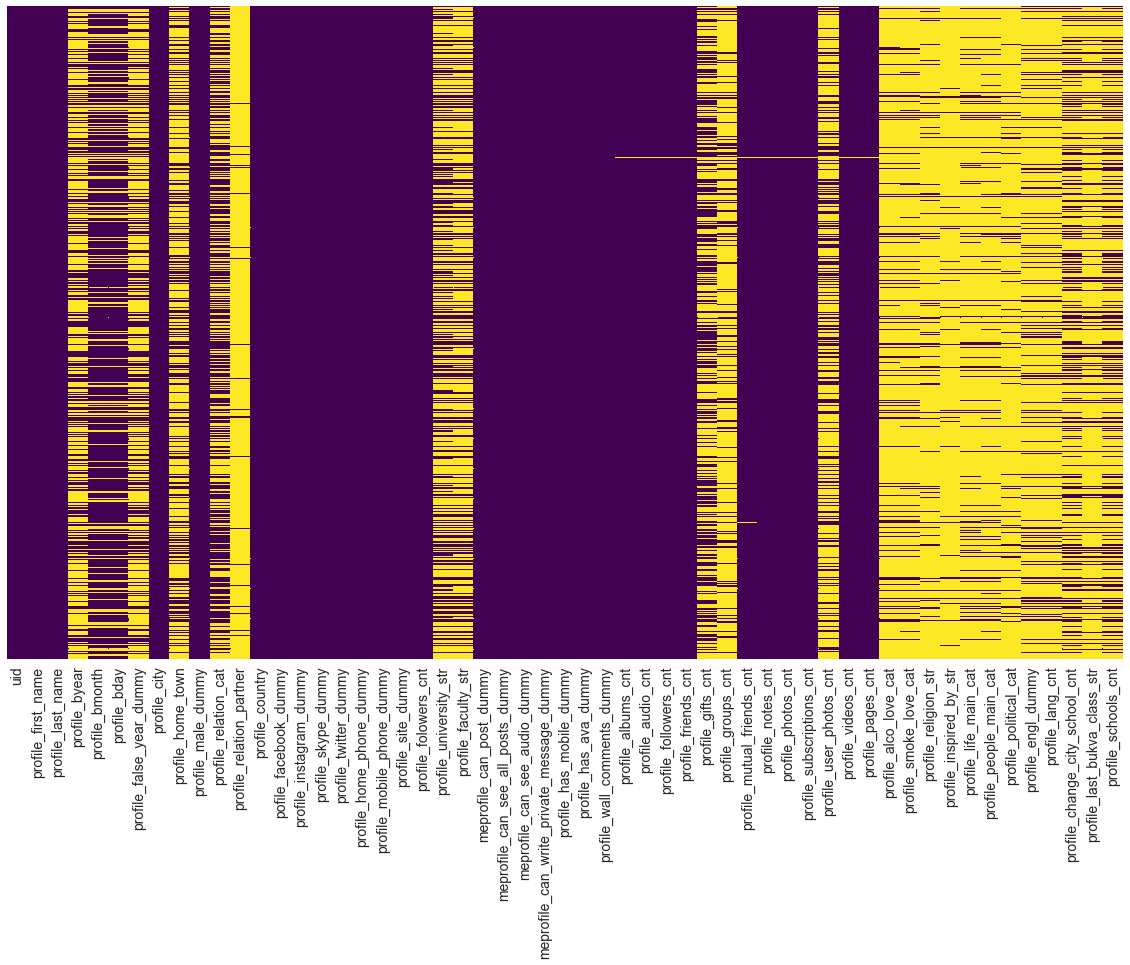

In [36]:
sns.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df_pr.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Text(0,0.5,'Число переменных')

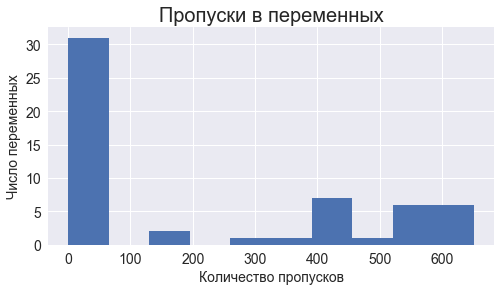

In [37]:
plt.figure(figsize=(8,4))
plt.hist(df_pr.isnull().sum()) 
plt.title('Пропуски в переменных', fontsize=20)
plt.xlabel('Количество пропусков', fontsize=14)
plt.ylabel('Число переменных', fontsize=14)

## 2.1 Обработка пропусков

Посмотрим что за пропуски такие и в каких переменных они встречаются. 

### 2.1.1 Переменные без пропусков 

In [38]:
vr_0 = [item for item in df_pr.columns if df_pr[item].isnull().sum() == 0]
print(len(vr_0))
vr_0

21


['uid',
 'profile_first_name',
 'profile_last_name',
 'profile_city',
 'profile_male_dummy',
 'profile_country',
 'pofile_facebook_dummy',
 'profile_instagram_dummy',
 'profile_skype_dummy',
 'profile_twitter_dummy',
 'profile_home_phone_dummy',
 'profile_mobile_phone_dummy',
 'profile_site_dummy',
 'profile_folowers_cnt',
 'meprofile_can_post_dummy',
 'meprofile_can_see_all_posts_dummy',
 'meprofile_can_see_audio_dummy',
 'meprofile_can_write_private_message_dummy',
 'profile_has_mobile_dummy',
 'profile_has_ava_dummy',
 'profile_wall_comments_dummy']

Без пропусков оказалась 21 переменная. Перевариваем их. 

In [39]:
df_pr_clean = pd.DataFrame( )  # Чистая табличка для переваренного добра 

In [40]:
# уид, имя и фамилию оставляем без изменений 
df_pr_clean['uids'] = df_pr['uid']
df_pr_clean['profile_first_name'] = df_pr['profile_first_name']
df_pr_clean['profile_last_name'] = df_pr['profile_last_name']

# переменная с городом проживания
# чаще всего он либо не указан, либо это Москва, преобразуем колонку в две дамми переменные
# возможно, имеет смысл сделать отедльную дамми на крупные города, но мне влом
df_pr_clean['profile_city_moscow_dummy'] = 1*(df_pr['profile_city'] == 'Москва')
df_pr_clean['profile_city_none_dummy'] = 1*(df_pr['profile_city'] == 'Город не указан')

# Страну также разбиваем на несколько дамми 
df_pr_clean['profile_country_russia_dummy'] = 1*(df_pr.profile_country == 'Россия' )
df_pr_clean['profile_country_none_dummy'] = 1*(df_pr.profile_country == 'Страна не указана')

# Число подписчиков 
df_pr_clean['profile_folowers_cnt'] = df_pr.profile_folowers_cnt

##### Много разных дамми-пеерменных ######

# Пол, указанный вк оставляем без изменений 
df_pr_clean['profile_male_dummy'] = df_pr.profile_male_dummy

# Есть ли у человека аватар 
df_pr_clean['profile_has_ava_dummy'] = df_pr.profile_has_ava_dummy

# Открыта ли стена для комментов 
df_pr_clean['profile_wall_comments_dummy'] = df_pr.profile_wall_comments_dummy

# Указана ли вк ссылка на facebook (указана у 19 человек)
df_pr_clean['profile_facebook_dummy'] = df_pr.pofile_facebook_dummy

# Указана ли ссылка на инстаграмм (указана у 135 человек)
df_pr_clean['profile_instagram_dummy'] = df_pr.profile_instagram_dummy

# Указана ли ссылка на skype (указана у 103 человек)
df_pr_clean['profile_skype_dummy'] = df_pr.profile_skype_dummy

# Указана ли ссылка на twitter (указана у 37 человек)
df_pr_clean['profile_twitter_dummy'] = df_pr.profile_twitter_dummy

# Указан ли домашнией телефон (указан у 39 человек)
df_pr_clean['profile_home_phone_dummy'] =  df_pr.profile_home_phone_dummy

# Указан ли у человека мобильник (указан у 125 человек) 
df_pr_clean['profile_mobile_phone_dummy'] =  df_pr.profile_mobile_phone_dummy

# указан ли какой-нибудь сайт (указан у 94 человек)
df_pr_clean['profile_site_dummy'] = df_pr.profile_site_dummy

##### немного странные дамми-переменные ###### 

# могу ли я писать на и комментиоровать стену (454 нет)
df_pr_clean['meprofile_can_post_dummy'] = df_pr.meprofile_can_post_dummy

# могу лия видеть все посты (352 нет)
df_pr_clean['meprofile_can_see_all_posts_dummy'] = df_pr.meprofile_can_see_all_posts_dummy

# могу ли я видеть аудио (416 нет)
df_pr_clean['meprofile_can_see_audio_dummy'] = df_pr.meprofile_can_see_audio_dummy

# могу ли я писать в личку  (62 нет)
df_pr_clean['meprofile_can_write_private_message_dummy'] = df_pr.meprofile_can_write_private_message_dummy

# Выбрасываем :  'profile_has_mobile_dummy'

### 2.1.2 Не более 100 пропусков 

А мы тем временем переходим к данным, в которых есть мене сотни пропусков. В основном, это переменные-счётчики. Все их нам бы хотелось оставит в выборке. В каждой из них не более двух пропусков. У людей закрыты страницы. Приватность так приватность, заполним эти пропуски нулями.

In [41]:
vr_100 = [item for item in df_pr.columns if 0 < df_pr[item].isnull().sum() < 100]
vr_100

['profile_albums_cnt',
 'profile_audio_cnt',
 'profile_followers_cnt',
 'profile_friends_cnt',
 'profile_mutual_friends_cnt',
 'profile_notes_cnt',
 'profile_photos_cnt',
 'profile_subscriptions_cnt',
 'profile_videos_cnt',
 'profile_pages_cnt']

In [42]:
# два раза встритилось followers_cnt. Скорее всего спарсено из разных источников
# удалим текущий 

vr_100 = list(set(vr_100) - { 'profile_followers_cnt'})

In [43]:
df_pr_clean[vr_100] =  df_pr[vr_100].fillna(0)

Движемся по числу пропусков дальше. 

### 2.1.3 От 100 до 300 пропусков 

In [44]:
vr_300 = [item for item in df_pr.columns if 100 < df_pr[item].isnull().sum() < 300]
vr_300

['profile_bmonth', 'profile_bday', 'profile_relation_cat']

In [45]:
print(df_pr.profile_bmonth.isnull().sum())
print(df_pr.profile_bday.isnull().sum())
print(df_pr.profile_relation_cat.isnull().sum())
df_pr[vr_300].head()

148
148
299


profile_bmonth  profile_bday profile_relation_cat
0             9.0          27.0           не указано
1             4.0          18.0                  NaN
2             2.0          13.0           не указано
3             NaN           NaN           не указано
4             NaN           NaN                  NaN

Все переменные категориальные с большим числом пропусков.  Мы условились, что пока что не будем их трогать. 

In [46]:
df_pr_clean['profile_bmonth_cat'] = df_pr.profile_bmonth
df_pr_clean['profile_bday_cat'] = df_pr.profile_bday

# заменяем все NaN на не указано и оставляем переменную категориальной 
df_pr_clean['profile_relation_cat'] = df_pr['profile_relation_cat'].fillna('не указано')

### 2.1.4 От 300 до 400 пропусков 


In [47]:
vr_300 = [item for item in df_pr.columns if 300 < df_pr[item].isnull().sum() < 400]
vr_300

['profile_university_str', 'profile_gifts_cnt']

In [48]:
df_pr.profile_university_str.value_counts()

РАНХиГС при Президенте РФ (АНХ при Правительстве РФ, РАГС при Президенте РФ)    214
МФТИ (ГУ)                                                                        36
НИУ ВШЭ (ГУ-ВШЭ)                                                                  6
МГУ                                                                               4
РУДН                                                                              2
СПбГУ                                                                             2
МГОУ (КФ)                                                                         1
СПбГУГА                                                                           1
РГУИТП                                                                            1
Université Paris I - Panthéon-Sorbonne                                            1
Московский политехнический университет (МАМИ и МГУП)                              1
Université catholique de Lille                                              

Преобразуем переменную, которая отвечает за ВУЗ в три дамми. Скорее всего тот факт, что кто-то не указал на своей страничке в качестве вуза __Российскую академию народного хозяйствао и государственной сложбы при президенте Российской Федерации,__ о чём-то говорит. Наши стешняшки <3 

In [49]:
# Дамми для ранепы
df_pr_clean['profile_vuz_ranepa_yes_dummy'] = \
1*(df_pr.profile_university_str == 'РАНХиГС при Президенте РФ (АНХ при Правительстве РФ, РАГС при Президенте РФ)')

# Дамми для пропусков 
df_pr_clean['profile_vuz_none_dummy'] = 1*(df_pr.profile_university_str.isnull())

# Всё остальное - другие вузы. Мы не должны попасть в дамми-ловушку! 

# Пропуски в подарках заполняем нулями 
df_pr_clean['profile_gifts_cnt'] = df_pr.profile_gifts_cnt.fillna(0)

### 2.1.5 От 400 до 500 пропусков 

Переходим к переменным, для которых число пропусков очень велико.

In [50]:
vr_400 = [item for item in df_pr.columns if 400 < df_pr[item].isnull().sum() < 500]
vr_400

['profile_byear',
 'profile_false_year_dummy',
 'profile_home_town',
 'profile_faculty_str',
 'profile_user_photos_cnt',
 'profile_change_city_school_cnt',
 'profile_schools_cnt']

In [51]:
df_pr[vr_400].head()

profile_byear  profile_false_year_dummy              profile_home_town  \
0         1997.0                       0.0                       Кострома   
1         1993.0                       0.0                            NaN   
2         1917.0                       1.0  Залупкино, Московская область   
3            NaN                       NaN                       Белгород   
4            NaN                       NaN                            NaN   

       profile_faculty_str  profile_user_photos_cnt  \
0  Экономический факультет                     96.0   
1                      NaN                      NaN   
2                      NaN                      0.0   
3                      NaN                      3.0   
4                      NaN                      NaN   

   profile_change_city_school_cnt  profile_schools_cnt  
0                             2.0                  2.0  
1                             NaN                  NaN  
2                             1.0                  1.0  
3                             NaN                  NaN  
4                             NaN                  NaN

In [52]:
# Всё, что отвечает за год рождения, выкидываем 

# Дамми отвечающая за то является ли москва для человека родным городом 
df_pr_clean['profile_moscow_hometown_dummy'] = 1*(df_pr.profile_home_town == 'Москва')

# Указан ли в профиле иканам 
df_pr_clean['profile_econom_yes_dummy'] = 1*(df_pr.profile_faculty_str == 'Экономический факультет')

# Сколько фоток у юзера в профиле 
df_pr_clean['profile_photos_cnt'] = df_pr.profile_user_photos_cnt.fillna(0)

# Информация про школу 
# Человек столько раз при смене школы поменял город. Переменная - категориальная
df_pr_clean['profile_change_city_school_cat'] = df_pr.profile_change_city_school_cnt
# Человек поменял в принципе школу столько раз. Переменная - категориальная
df_pr_clean['profile_schools_cat'] = df_pr.profile_schools_cnt

### 2.1.6 От 500 пропусков 

Больше всего пропусков в самых интересных переменных, отвечающих за политические взгляды, отношение к куреню и прочие подобные вещи. Все такие категориальные фичи мы оставим без изменений. Интересно будет посмотреть на людей, которые указываи о себе хоть что-то. В конечном счёте мы выбросим все эти переменные из рассмотрения сразу после визуализаций. 

In [53]:
vr_500 = [item for item in df_pr.columns if df_pr[item].isnull().sum() > 500]
vr_500

['profile_relation_partner',
 'profile_groups_cnt',
 'profile_alco_love_cat',
 'profile_smoke_love_cat',
 'profile_religion_str',
 'profile_inspired_by_str',
 'profile_life_main_cat',
 'profile_people_main_cat',
 'profile_political_cat',
 'profile_engl_dummy',
 'profile_lang_cnt',
 'profile_last_bukva_class_str']

In [54]:
# Дамми, равная 1, если указан партнёр по отношениям
df_pr_clean['profile_relation_partner_yes_dummy'] = 1- 1*(df_pr.profile_relation_partner.isnull())

# Дамми, равная 1, если человек скрыл группы (не паблики)
df_pr_clean['profile_group_hide_dummy'] = 1*(df_pr.profile_groups_cnt.isnull())
# Число групп, в которых состоит человек. Пропуски заполнены нулями
df_pr_clean['profile_group_hide_dummy'] = df_pr.profile_groups_cnt.fillna(0)

# Указан ли английский язык как второй в профиле 
df_pr_clean['profile_engl_dummy'] = 1*(df_pr.profile_engl_dummy == 1)

# Число языков, которое указано в профиле. Пропуски - 0. Ничего же не указано... 
df_pr_clean['profile_lang_cnt'] = df_pr.profile_lang_cnt.fillna(0)

# Все категориальные фичи оставляем без изменений, чтобы потом поугарать 
cat_var = ['profile_alco_love_cat','profile_smoke_love_cat','profile_life_main_cat',
           'profile_people_main_cat','profile_political_cat'] 

df_pr_clean[cat_var] = df_pr[cat_var]

# Поугараем над тем кто какую религию и веру указал у себя в профиле и выбросим эти переменные
# Переменная, отвечающая за букву класса сварилась плохо, её также выкидываем 

In [55]:
df_pr.profile_religion_str.value_counts()

Православие                                                           26
Светский гуманизм                                                      8
Буддизм                                                                5
Атеизм                                                                 4
Ислам                                                                  4
Orthodoxy                                                              3
Пастафарианство                                                        3
атеист                                                                 2
Агностицизм                                                            1
†                                                                      1
Христианство и православие                                             1
Христианство                                                           1
Агностик                                                               1
Деизм                                              

In [56]:
df_pr.profile_inspired_by_str.value_counts()

Дензел Вашингтон, Криштиану Роналду, Вишен Лакиани, Тони Роббинс                                                                                                                             1
Столичная, Пять озер, Двойная Золотая, Хаски, Граф Ледофф, Белочка: я пришла!, Медофф Люкс, Байкал, Дудка, Талка, Цельсий Классик, Журавли, Белый ключ, Финляндия(не Финская!), Беленькая    1
Steve Jobs, Mahatma Gandhi, Mother Teresa, Bill Gates                                                                                                                                        1
Девушки, красивая природа, спортзал, тайский бокс                                                                                                                                            1
человечность                                                                                                                                                                                 1
Книги, люди, музыка                          

Сохраним таблицу в двух форматах. Данные по профилям, по всем людям и в объединении с базовой таблицей. 

In [57]:
df_pr_clean.to_csv('data_all_prof.csv', sep='\t', index=False, header=True)
print(df_pr_clean.shape)

# Объединяем с первой табличкой 
total_df_1 = pd.merge(total_df, df_pr_clean, on = 'uids', how='inner')
print(total_df_1.shape)

total_df_1.to_csv('data2_prof.csv', sep='\t', index=False, header=True)

(674, 50)
(418, 72)


## 2.2 Визуализации

Посмотрим на корреляции признаков, чтобы узнать, не нужно ли удалять какие-то признаки перед построением модели. Если между признаками высокая корреляция, это может привести к мультиколиниарности и невозможности оценить модель.

Для визуализации матрицы попарных корреляций удобно использовать функцию `seaborn.heatmap`, она автоматически подпишет признаки на осях и покажет colorbar. Мы вычисляем корреляции только между вещественными признаками, для целочисленных признаков корреляции вычисляется по другим формулам.

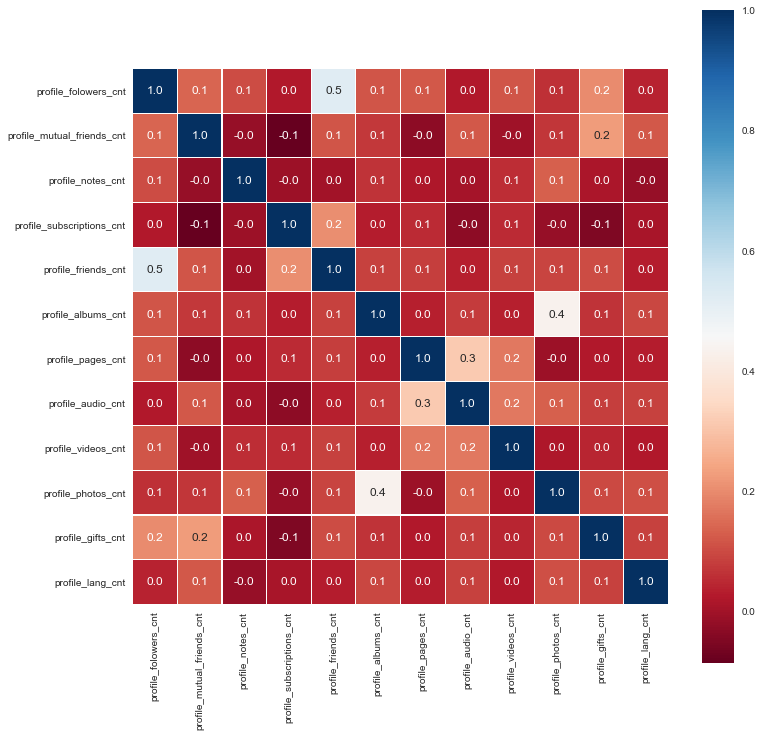

In [58]:
var_cat = [var for var in df_pr_clean.columns if (var[-3:] == 'cat')|(var[-3:] == 'mmy')] + ['uids']

sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df_pr_clean.drop(var_cat, axis=1).corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

В целом всё ок. Посмотрим на распределение отчислений по полу. 

In [59]:
pd.crosstab(total_df_1['target_1'], total_df_1['profile_male_dummy'], normalize=True)

profile_male_dummy     0     1
target_1                      
0.0                 0.16  0.11
1.0                 0.49  0.23

# 3. Данные по фоткам 

## 3.1 Заполняем пропуски 

По фотографиям мы сварили не очень большое, но довольно хорошо заполненное число переменных. Посмотрим на них чуть более подробно. Все созданные нами при скачке данных переменные, в основном, являются счётчиками. В связи с этим заполним все пропуски нулями. 

In [62]:
df_ph = pd.read_csv('vk_photo_data_v18-12-17.csv', sep = '\t', index_col=0)
print('С удалёнными:', df_ph.shape)

# Убрали удалённые странички 
df_ph = pd.merge(df_ph, df_pr[['uid']], on = 'uid', how='right')
print('Без удалённых:', df_ph.shape) 

С удалёнными: (707, 19)
Без удалённых: (674, 19)


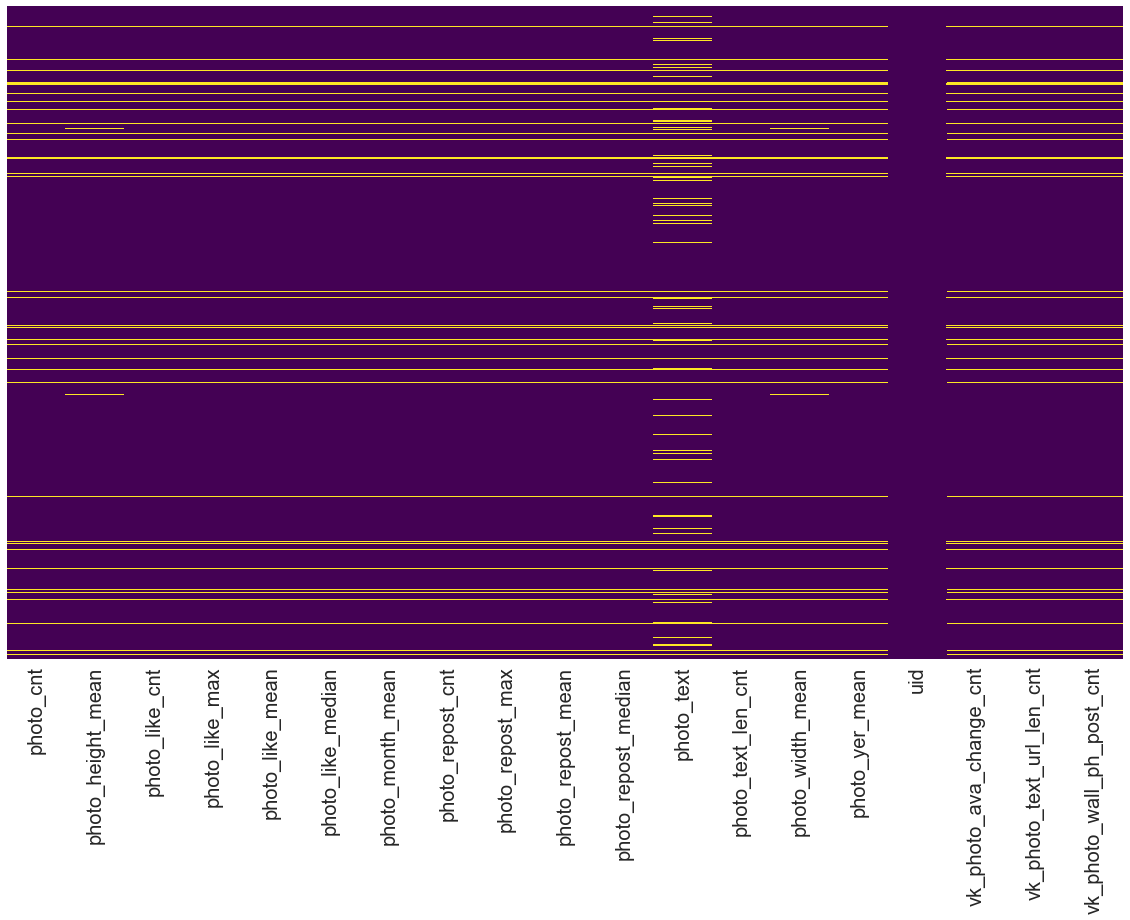

In [63]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df_ph.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Text(0,0.5,'Число переменных')

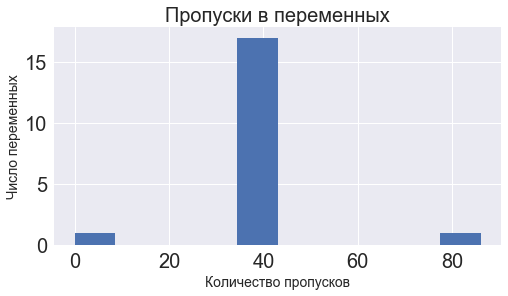

In [64]:
plt.figure(figsize=(8,4))
plt.hist(df_ph.isnull().sum()) 
plt.title('Пропуски в переменных', fontsize=20)
plt.xlabel('Количество пропусков', fontsize=14)
plt.ylabel('Число переменных', fontsize=14)

In [65]:
df_ph_clean = pd.DataFrame() 
 
variables = ['photo_cnt', 'photo_height_mean',   'photo_width_mean',   'photo_like_max',   'photo_like_mean', 
         # Число фоток     средняя высота фото  средняя ширина фото   максимально лайков    средне лайков      
         #                     (лол што)             (ЗАЧЕМ)              под фото             под фото 

        'photo_like_median', 'photo_repost_cnt',  'photo_repost_max',  'photo_repost_mean', 'photo_repost_median',
         # медиана лайков       число репостов       максимально            среднее              медиана  
       
        'vk_photo_ava_change_cnt', 'vk_photo_wall_ph_post_cnt',     'photo_text_len_cnt',      
         # сколько аватарок            сколько фоток на стене       длина подписей под фото 
         
         'vk_photo_text_url_len_cnt',   'photo_month_mean',        'photo_yer_mean']
         # длина ссылок под фото       в среднем выложил фоток    в среднем выложил фоток
         #                                  за месяц                  за год 
 
 # все пропуски заполняем нулями
df_ph_clean[variables] = df_ph[variables].fillna(0)
df_ph_clean['uids'] = df_ph['uid']

Текст, который обычно оставляют под фотками, и который мы тоже скачали, сам по себе проигнорируем. 

In [66]:
df_ph['photo_text'][:20]

0                Создано в приложение ФотоСтатус - v...
1                                                      
2                                                      
3           лето**          Мамуля ...)             ...
4          Я выиграл партию в монополию vk.com/magna...
5                                                   ...
6                               by Valeriya Pavlova ...
7                                                      
8            Коллекция: Готическая комната. Шляпа- У...
9                                                      
10                                                     
11                                                  NaN
12     Original: http://cs413126.vk.me/v413126772/29...
13      2017, Бангкок.  Местечко во дворце короля 20...
14                                                  ...
15                                                  ...
16                                                  ...
17                                              

## 3.2 Визуализации и чистка

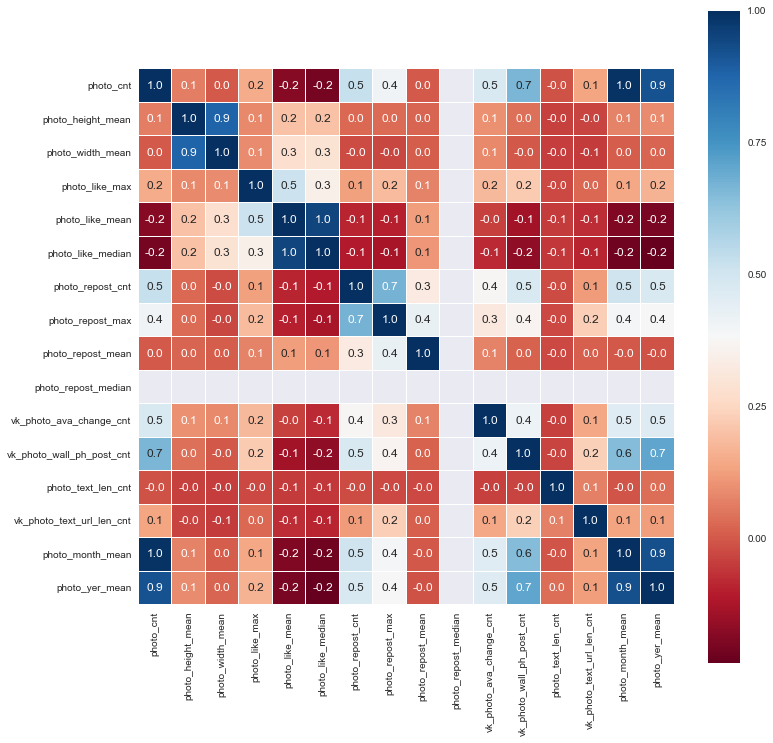

In [67]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df_ph_clean.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

In [68]:
df_ph_clean.drop(['photo_cnt', 'photo_yer_mean', 'photo_width_mean', 'photo_height_mean',
                 'photo_like_median', 'photo_repost_max','photo_repost_median'],axis=1,inplace=True)

Сохраняем данные по фоткам в виде двух табличек. Вместе с основной и как отдельную. 

In [69]:
# Отдельно 
df_ph_clean.to_csv('data_all_photo.csv', sep='\t', index=False, header=True)
print(df_ph_clean.shape)

# Объединяем
total_df_2 = pd.merge(total_df_1, df_ph_clean, on = 'uids', how='inner')
print(total_df_2.shape)

total_df_2.to_csv('data3_prof_ph.csv', sep='\t', index=False, header=True)

(674, 10)
(418, 81)


# 4. Данные по стенам  

## 4.1 Заполняем пропуски 

In [70]:
df_wl = pd.read_csv('vk_wall_data_v18-12-17.csv', sep = '\t', index_col=0)
print('С удалёнными:', df_wl.shape)

# Убрали удалённые странички 
df_wl = pd.merge(df_wl, df_pr[['uid']], on = 'uid', how='right')
print('Без удалённых:', df_wl.shape) 

С удалёнными: (707, 108)
Без удалённых: (674, 108)


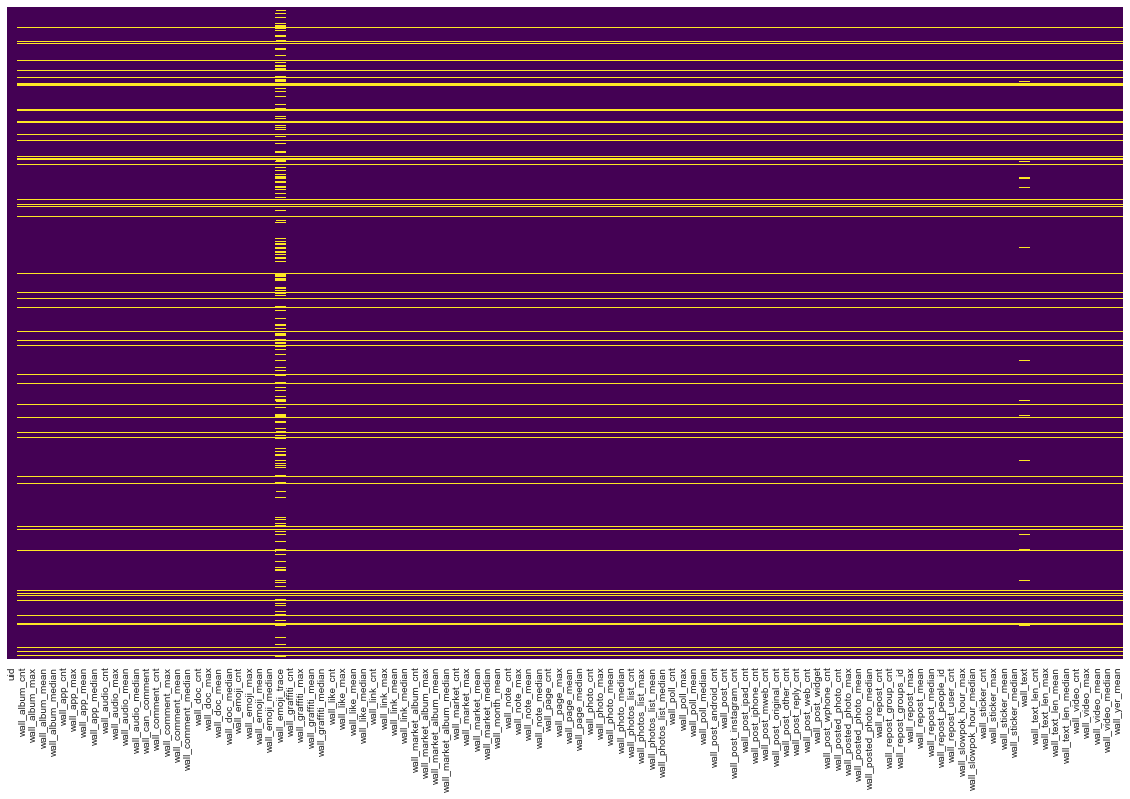

In [71]:
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df_wl.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Text(0,0.5,'Число переменных')

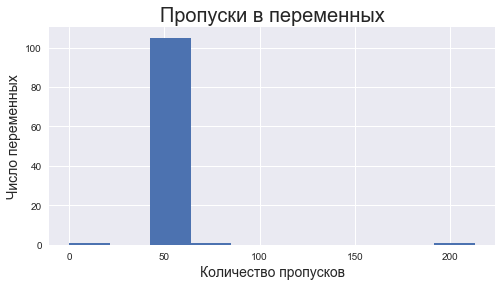

In [72]:
plt.figure(figsize=(8,4))
plt.hist(df_wl.isnull().sum()) 
plt.title('Пропуски в переменных', fontsize=20)
plt.xlabel('Количество пропусков', fontsize=14)
plt.ylabel('Число переменных', fontsize=14)

Дву сотни пропусков находится в переменной, которая называется `emoji_trace`...  Трэшаком мы уже занимались, здесь мы проигнорируем эту переменную. Также проигнорируем `wall_text`.

Пройдёмся по всем остальным переменным. Как и в прошлом случае, там, по большей части, одни счётчики. Поэтому будем заполнять все пропуски нулями. 

In [73]:
df_wl['uids'] = df_wl['uid']
df_wl.drop(['wall_text','wall_emoji_trace','uid'],axis=1,inplace=True)
df_wl = df_wl.fillna(0)
df_wl.head()

wall_album_cnt  wall_album_max  wall_album_mean  wall_album_median  \
0             0.0             0.0              0.0                0.0   
1             0.0             0.0              0.0                0.0   
2             0.0             0.0              0.0                0.0   
3             0.0             0.0              0.0                0.0   
4             0.0             0.0              0.0                0.0   

   wall_app_cnt  wall_app_max  wall_app_mean  wall_app_median  wall_audio_cnt  \
0           0.0           0.0            0.0              0.0            39.0   
1           0.0           0.0            0.0              0.0             7.0   
2           0.0           0.0            0.0              0.0             2.0   
3           0.0           0.0            0.0              0.0            93.0   
4           0.0           0.0            0.0              0.0             1.0   

   wall_audio_max    ...     wall_text_len_cnt  wall_text_len_max  \
0             9.0    ...                6101.0              830.0   
1             3.0    ...                4303.0             3961.0   
2             1.0    ...                1171.0             1014.0   
3             5.0    ...               25370.0             2588.0   
4             1.0    ...                5771.0             5771.0   

   wall_text_len_mean  wall_text_len_median  wall_video_cnt  wall_video_max  \
0               61.63                  17.0             8.0             7.0   
1              172.12                   0.0             0.0             0.0   
2              146.38                   0.5             0.0             0.0   
3               74.40                  45.0            16.0             5.0   
4             1923.67                   0.0             1.0             1.0   

   wall_video_mean  wall_video_median  wall_yer_mean      uids  
0             0.08                0.0          16.50  2.23e+07  
1             0.00                0.0           8.33  2.95e+08  
2             0.00                0.0           4.00  1.74e+08  
3             0.05                0.0          48.71  1.37e+08  
4             0.33                0.0           1.00  4.72e+07  

[5 rows x 106 columns]

## 4.2 Немного статитсики и визуализаций 

Для начала выделим в перменных более маленькие группки и внимательно взглянем на них. 

In [74]:
# Переменные счётчики 
var_cnt = [var for var in df_wl.columns.get_values() if var[-3:] == 'cnt']
# Реальные переменные
var_real = [var for var in df_wl.columns.get_values() if (var[-3:] == 'ean')|(var[-3:] == 'ian')|(var[-3:] == 'max') ]
# Ещё пара переменных 
set(df_wl.columns.get_values()) - set(var_cnt) - set(var_real)

{'uids',
 'wall_can_comment',
 'wall_post_widget',
 'wall_repost_groups_id',
 'wall_repost_people_id'}

Посмотрим на то насколько сильно коррелирвоаны между собой счётчики. Взглянув на матрицу, неожиданно выясним, что по части переменных у нас все наблюдения нулевые. Такие переменные мы выбрасываем из рассмотрения. wall_ap_cnt (посты на стенке из приложений), wall_market_album_cnt, wall_market_cnt (товары, выложенные для продажи), wall_post_reply(ответы на стене), wall_stickers (стикеры на стене).

Сразу же удалим из рассмотрения все средние, максимальные и медианные значения этих переменных. Иначе на второй матрице корреляций мы также увидим пустоты.

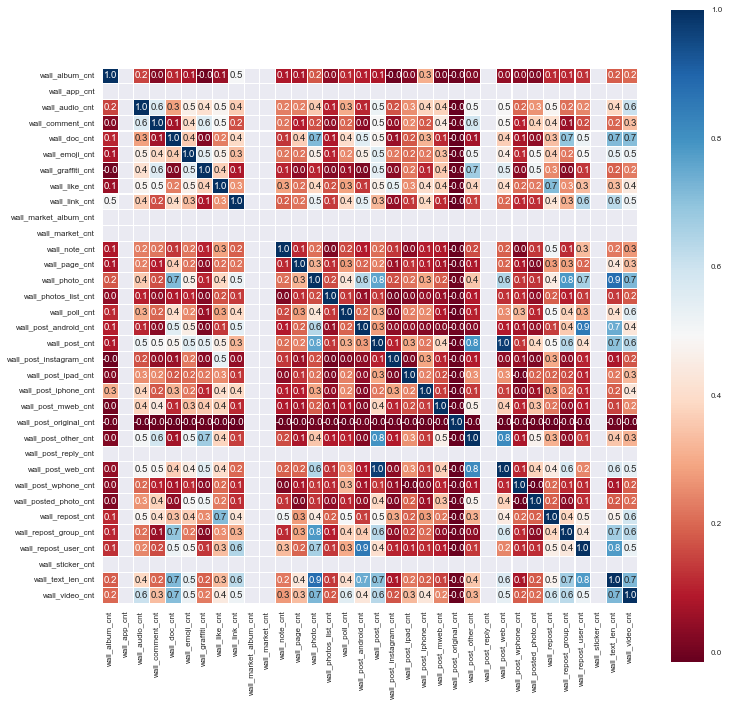

In [75]:
sns.set(font_scale=0.8)
plt.subplots(figsize=(12, 12))
sns.heatmap(df_wl[var_cnt].corr(), square=True,annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

In [76]:
df_wl.drop([ # Просто плохие перменные
             'wall_app_cnt','wall_app_max','wall_app_mean','wall_app_median',
             'wall_market_album_cnt','wall_market_album_max','wall_market_album_mean','wall_market_album_median',
             'wall_market_max', 'wall_market_mean','wall_market_cnt','wall_market_median',
             'wall_post_reply_cnt', 
             'wall_sticker_cnt','wall_sticker_max', 'wall_sticker_mean','wall_sticker_median',
           ], 
              axis=1,inplace=True)

In [77]:
df_wl.columns

Index(['wall_album_cnt', 'wall_album_max', 'wall_album_mean',
       'wall_album_median', 'wall_audio_cnt', 'wall_audio_max',
       'wall_audio_mean', 'wall_audio_median', 'wall_can_comment',
       'wall_comment_cnt', 'wall_comment_max', 'wall_comment_mean',
       'wall_comment_median', 'wall_doc_cnt', 'wall_doc_max', 'wall_doc_mean',
       'wall_doc_median', 'wall_emoji_cnt', 'wall_emoji_max',
       'wall_emoji_mean', 'wall_emoji_median', 'wall_graffiti_cnt',
       'wall_graffiti_max', 'wall_graffiti_mean', 'wall_graffiti_median',
       'wall_like_cnt', 'wall_like_max', 'wall_like_mean', 'wall_like_median',
       'wall_link_cnt', 'wall_link_max', 'wall_link_mean', 'wall_link_median',
       'wall_month_mean', 'wall_note_cnt', 'wall_note_max', 'wall_note_mean',
       'wall_note_median', 'wall_page_cnt', 'wall_page_max', 'wall_page_mean',
       'wall_page_median', 'wall_photo_cnt', 'wall_photo_max',
       'wall_photo_mean', 'wall_photo_median', 'wall_photos_list_cnt',
       

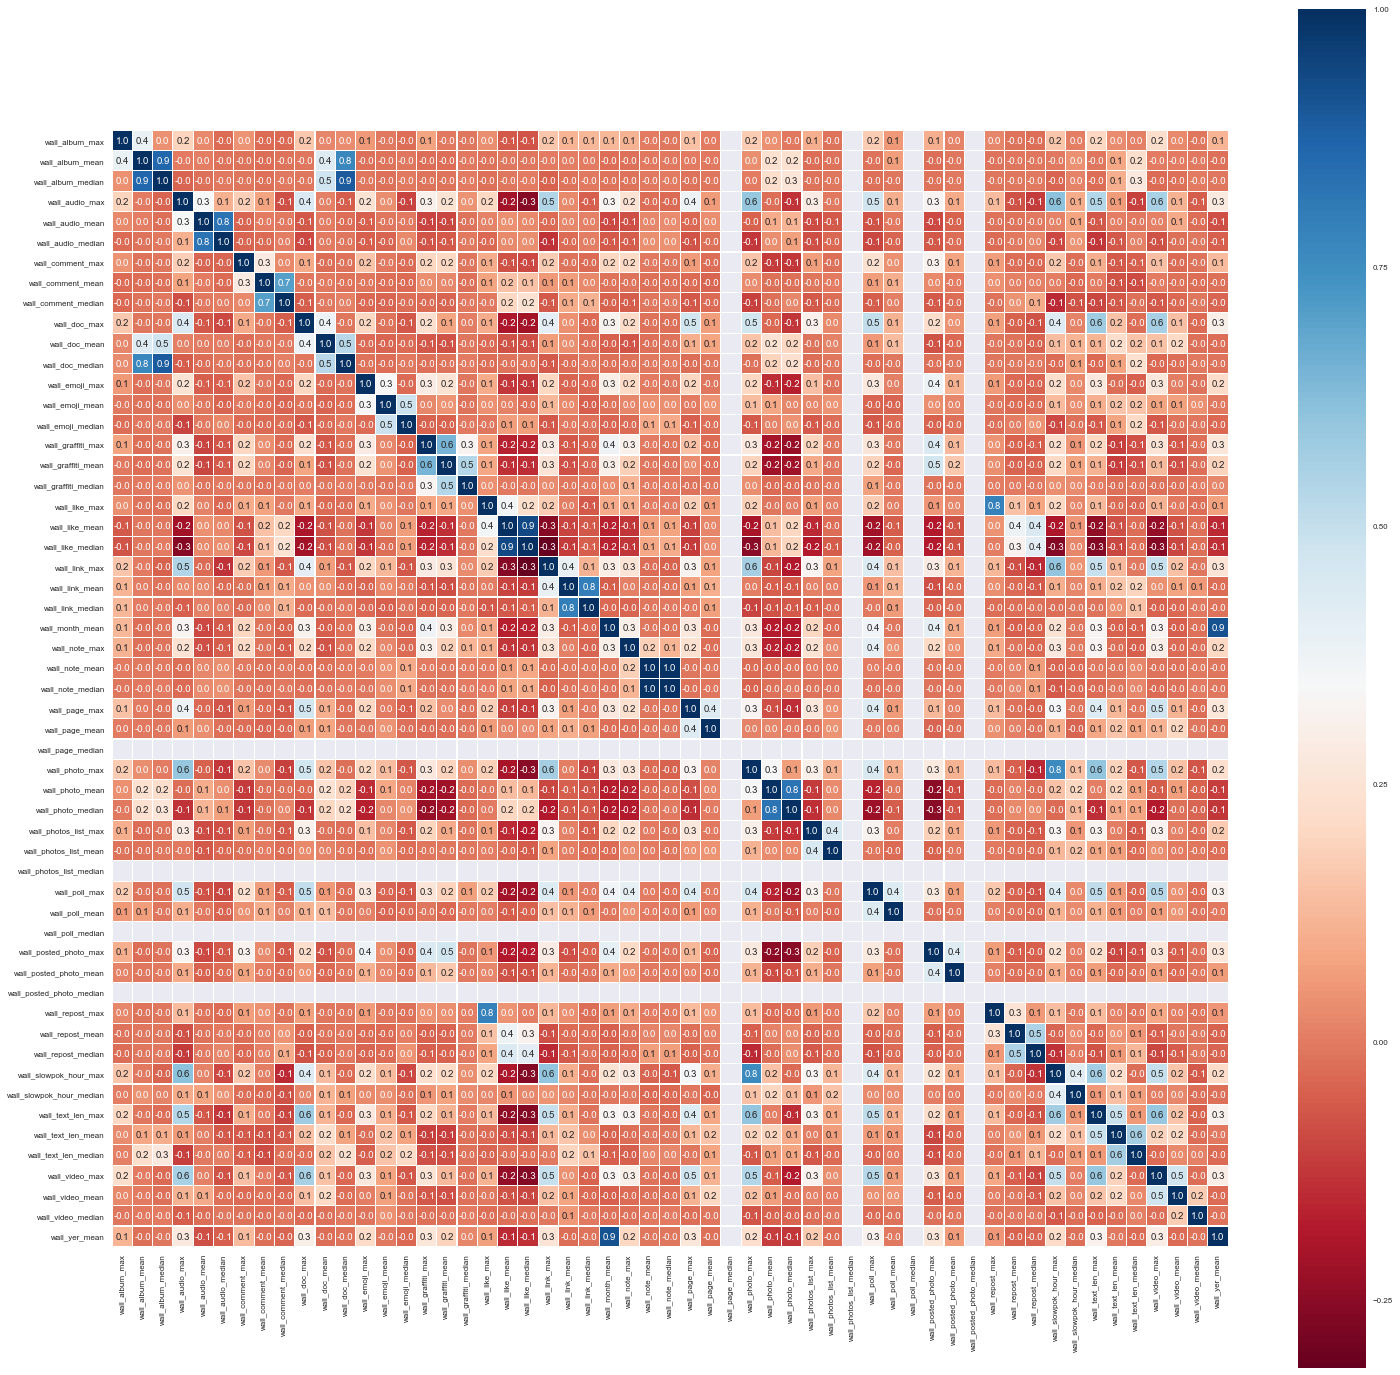

In [78]:
# обновляем список переменных
var_real = [var for var in df_wl.columns.get_values() if (var[-3:] == 'ean')|(var[-3:] == 'ian')|(var[-3:] == 'max') ]

plt.subplots(figsize=(25, 25))
sns.heatmap(df_wl[var_real].corr(), square=True,annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Продолжаем избавляться от мусора. Все средние довольно сильно коррелируют с медианами (как неожиданно). Это может привести к проблемам. Более того, некоторые медианы принимают только нулевые значения и дают нулевую корреляцтю с любой из других переменных. Выбрасываем все медианы.

In [79]:
var_median = [var for var in df_wl.columns.get_values() if (var[-3:] == 'ian')]
df_wl.drop(var_median,axis=1,inplace=True)

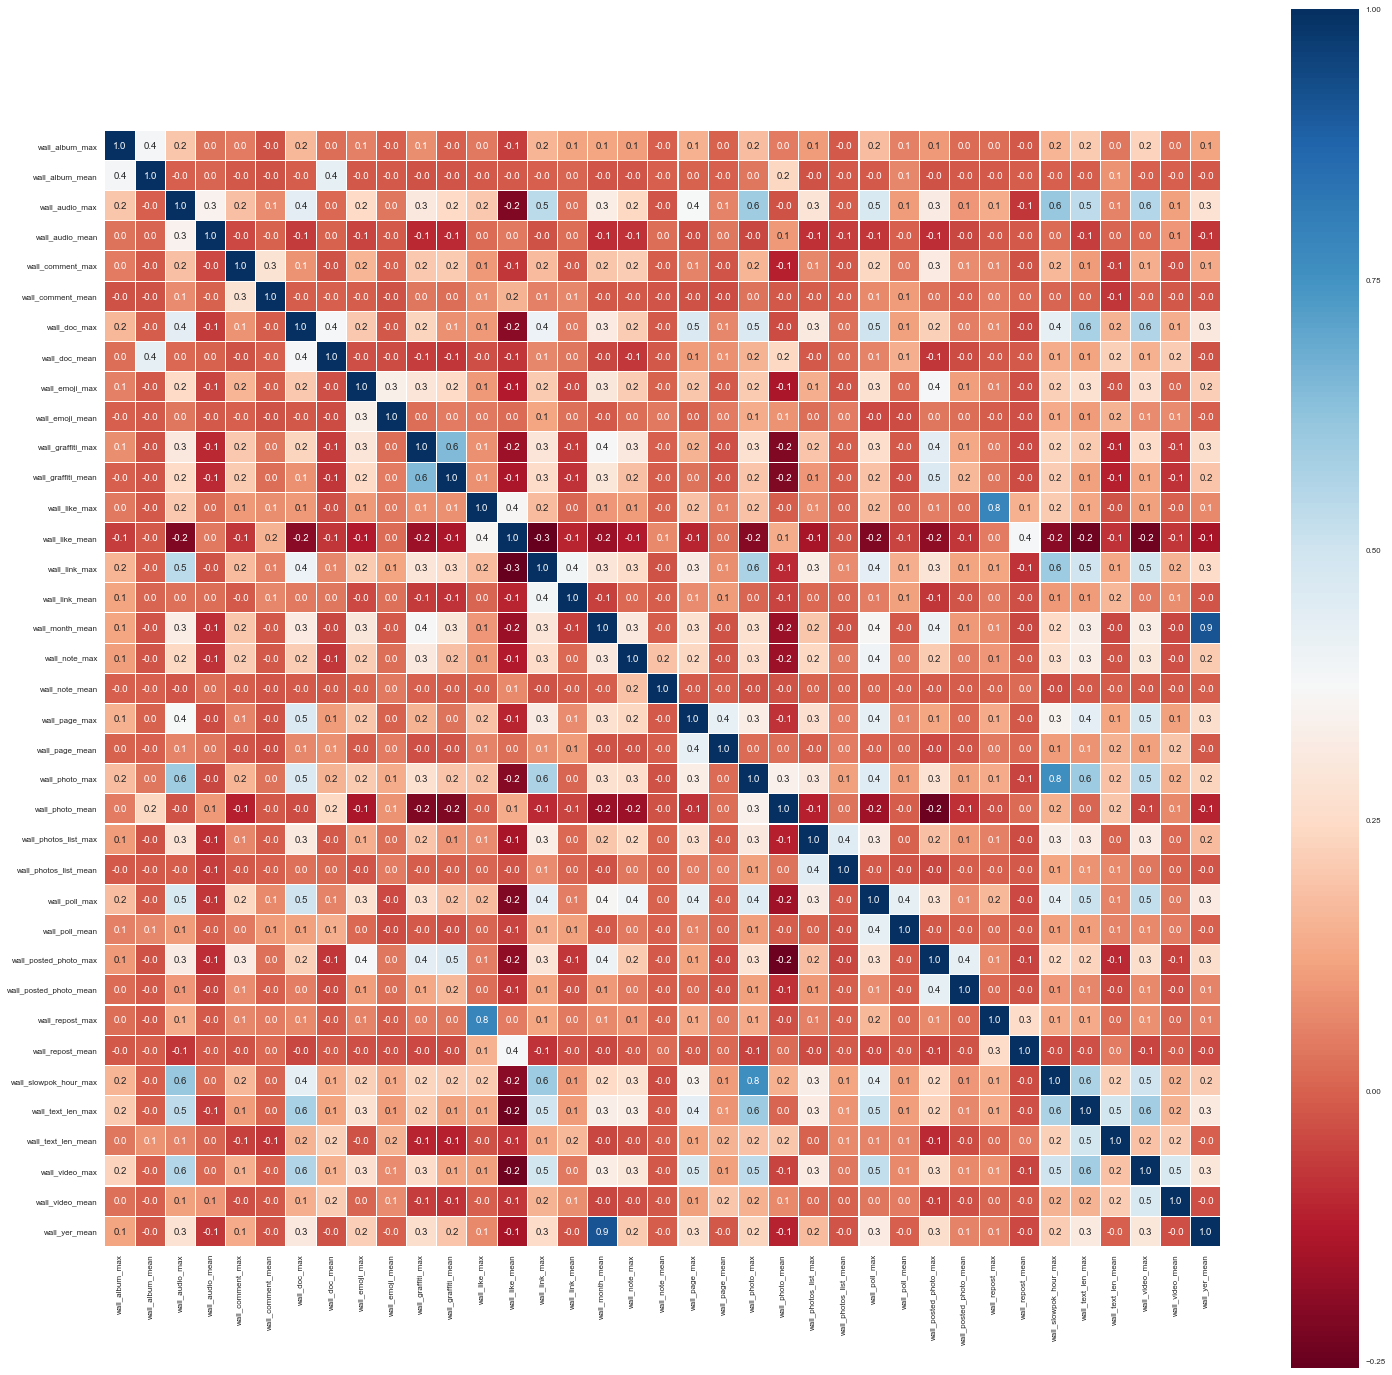

In [80]:
# обновляем список переменных
var_real = [var for var in df_wl.columns.get_values() if (var[-3:] == 'ean')|(var[-3:] == 'max') ]

plt.subplots(figsize=(25, 25))
sns.heatmap(df_wl[var_real].corr(), square=True,annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Посмотрим какие ещё остались сильные корреляции. Максимальное число репостов сильно коррелирует с максимальным числом лайков. Удалим переменную с рупостами. Среднее количество постов за год сильно коррелирует со средним числом постов за месяц. Уалим среднее число постов за год. Остальное находится в рамках приличия. 

In [81]:
df_wl.drop(['wall_yer_mean', 'wall_repost_max'], axis=1, inplace=True)
df_wl.shape

(674, 69)

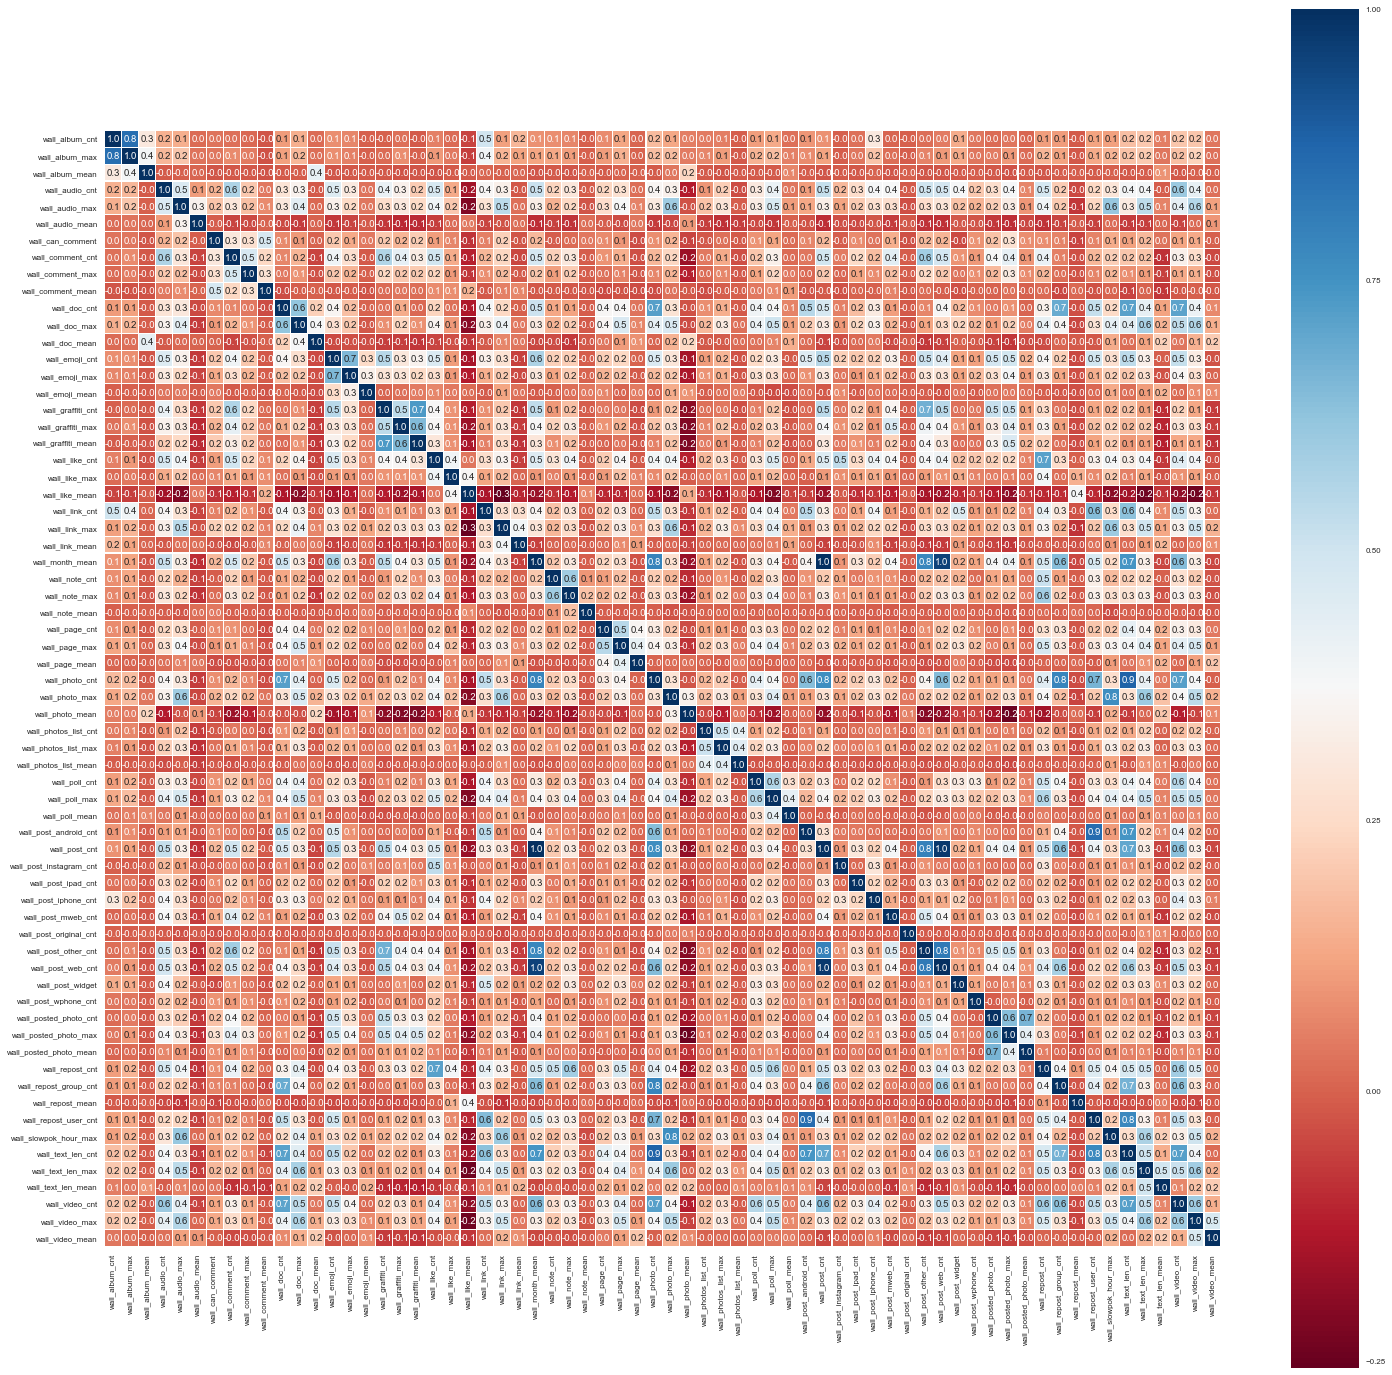

In [82]:
plt.subplots(figsize=(25, 25))
sns.heatmap(df_wl.drop(['uids','wall_repost_groups_id','wall_repost_people_id'],axis=1).corr(), 
             square=True,annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Видим ещё нескольк пар очень сильно связанных переменных. В первую группу входят: длина стены, среднее число постов за месяц, число постов с веб-странички, число постов с других устройств. Более того, часть счётчиков коррелирует с максимумами, что тоже ожидаемо. Такое обычно происходит, когда счётчик является довольно редким. Выкидываем все максимумы, которые этим грешат. 

In [83]:
df_wl.drop(['wall_post_web_cnt', 'wall_post_other_cnt','wall_month_mean' ,'wall_doc_max',
            'wall_album_max', 'wall_emoji_max', 'wall_graffiti_max', 'wall_graffiti_mean', 'wall_note_max',
            'wall_poll_max','wall_posted_photo_max','wall_posted_photo_mean','wall_video_max','wall_audio_max',
            'wall_text_len_cnt' ],axis=1,inplace=True)

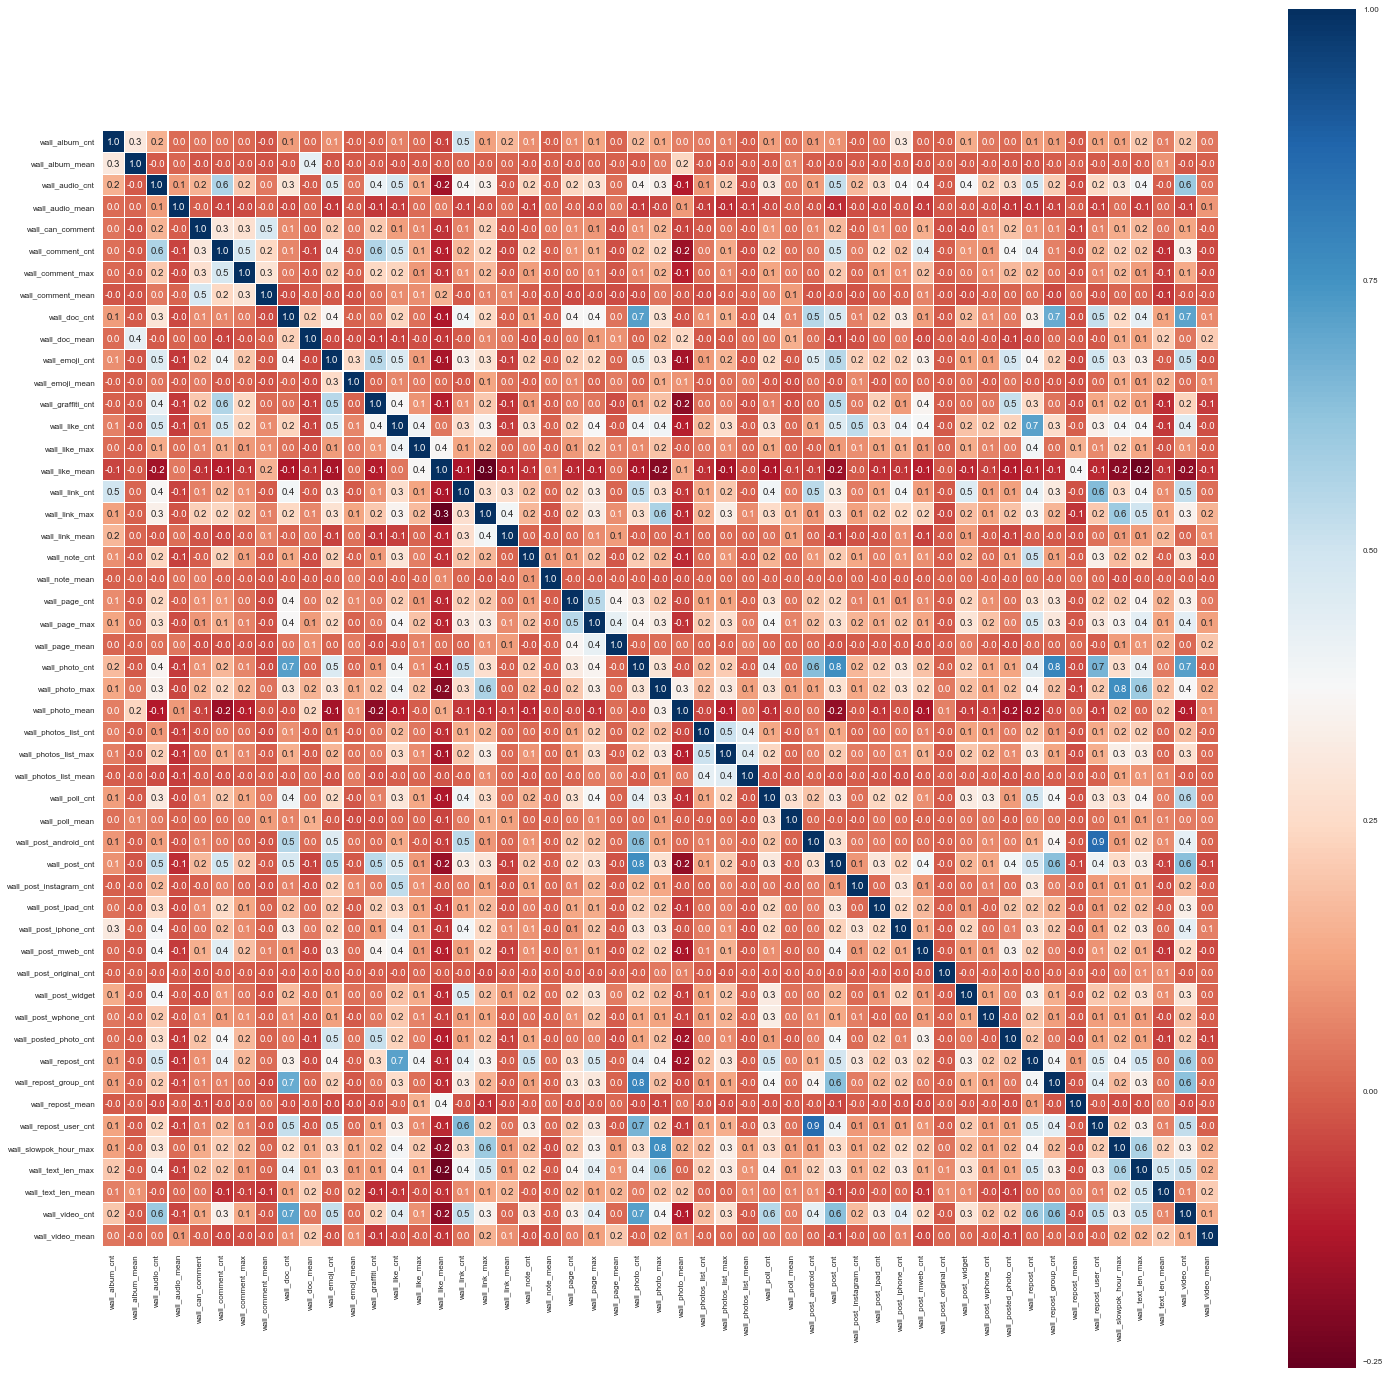

In [84]:
plt.subplots(figsize=(25, 25))
sns.heatmap(df_wl.drop(['uids','wall_repost_groups_id','wall_repost_people_id'],axis=1).corr(), 
             square=True,annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Отлично! В матрице осталась ещё парочка сильных корреляций. Некоторые из них удивляют. Например, корреяляция 0.9 стоит между реостами других потзователей и количеством постов с андроида. Массового андроида при этом на экономе вроде как не наблюдается. 

Количество фоток очень сильно связано с числом репостов других групп и в принципе числом постов. Удалим photo_cnt из выборки. Также забавно, что переменная, отвечаюзая за промежуток между постом и репостом, сильно коррелирует с длиной стены и числом фоток. Наверное, на остальные корреляции мы забьём. В случае сингулярности, мы знаем что следует вычистить. 

In [85]:
df_wl.drop(['wall_photo_cnt','wall_repost_user_cnt','wall_repost_group_cnt',],axis=1,inplace=True)

Сохранем наработки в виде двух табличек. 

In [86]:
# Отдельно 
df_wl.to_csv('data_all_wl.csv', sep='\t', index=False, header=True)
print(df_wl.shape)

# Объединяем
total_df_3 = pd.merge(total_df_2, df_wl, on = 'uids', how='inner')
print(total_df_3.shape)

(674, 51)
(418, 131)


Смотрим на общие корреляции. Какие-то переменные опять придётся дропнуть. 

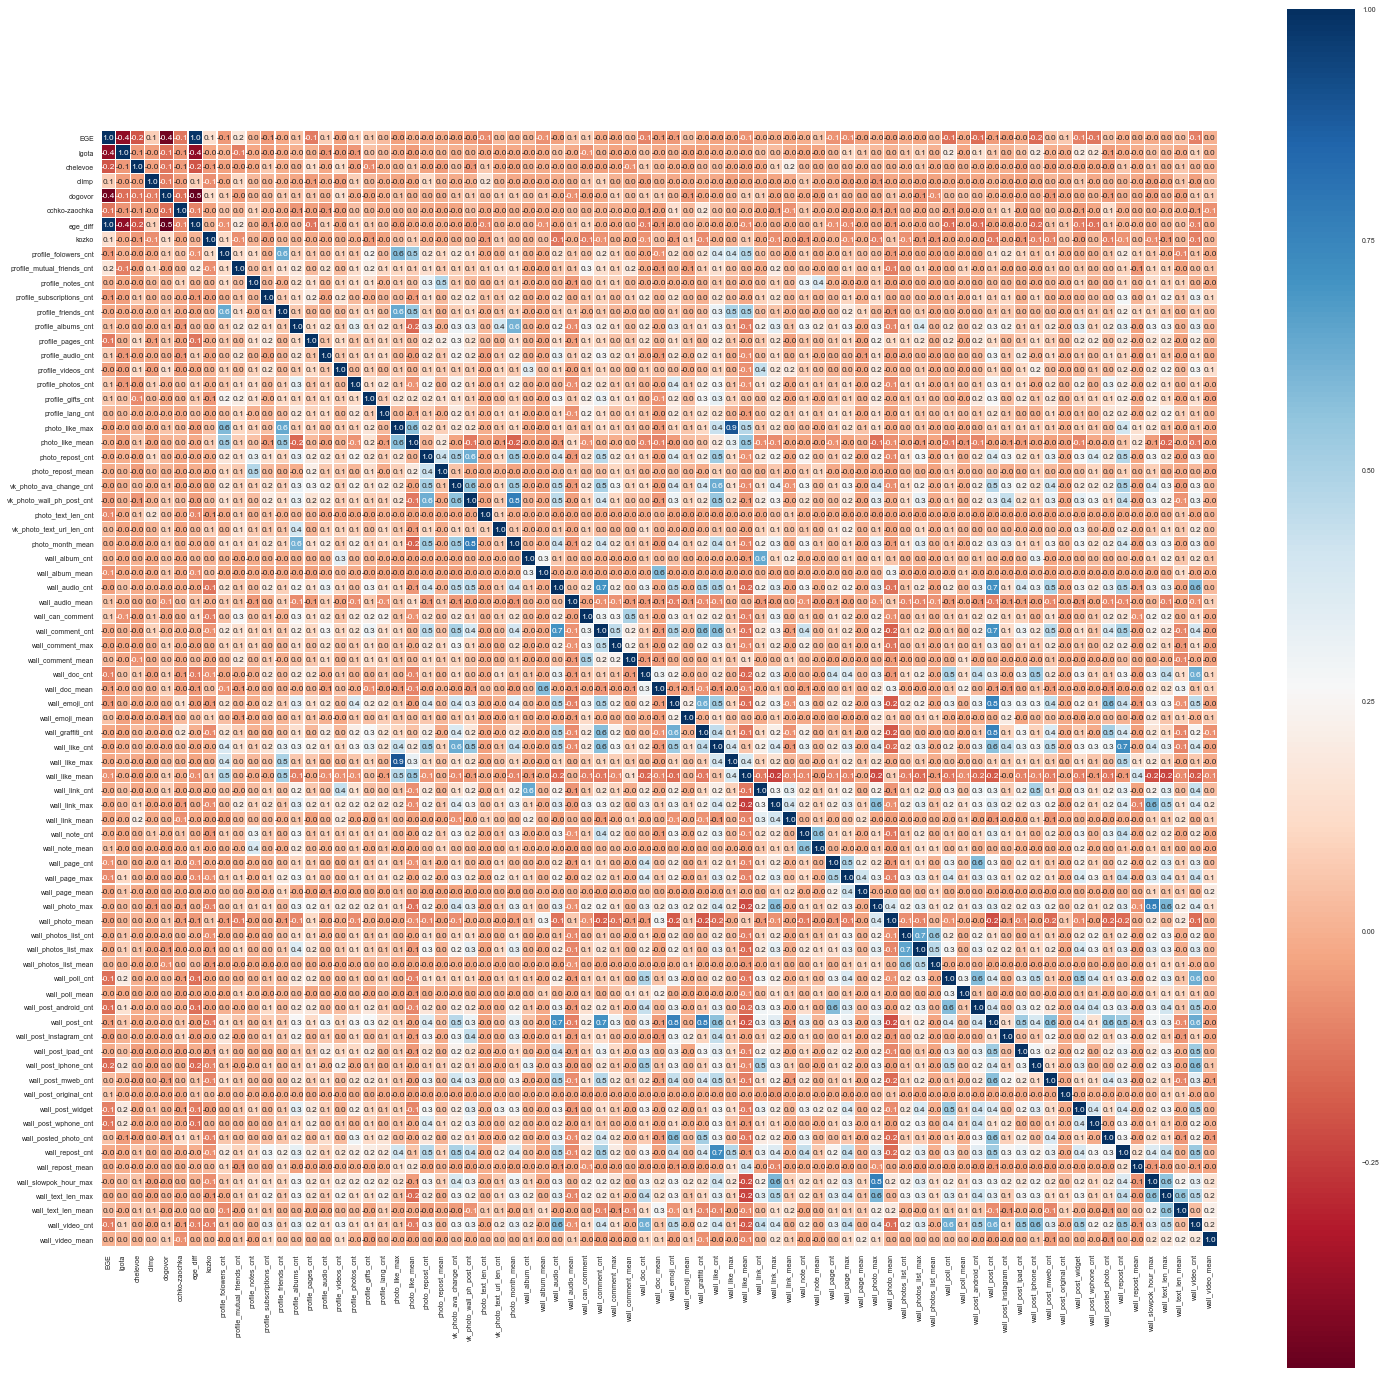

In [87]:
var_dl = [var for var in total_df_3.columns.get_values() if (var[-3:]=='mmy')|(var[-3:]=='cat')]

sns.set(font_scale=0.7)
plt.subplots(figsize=(25, 25))
sns.heatmap(total_df_3.drop(var_dl + ['uids', 'firstname', 'lastname', 'year','zima','leto',
                                      'kurs', 'prohodnoy','akadem','hodit_para','hodit_tusa',
                              'target_1', 'target_2', 'target_3', 'target_4'],axis=1).corr(), 
             square=True,annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Новые корреляции. `photo_like_max` и `wall_like_max`. Аватары выкладывают на стенку и срывают куг по лайкам. Также выкидываем `wall_photo_list_max`, потому что это $10$ и сильно коррелирует со счётчиком. Также мы забыли выбрость `EGE`, на основе которого сварили `ege_diff`, который учитывает проходной балл. 

In [88]:
total_df_3.drop(['photo_like_max','wall_photos_list_max','EGE'],axis=1,inplace=True)

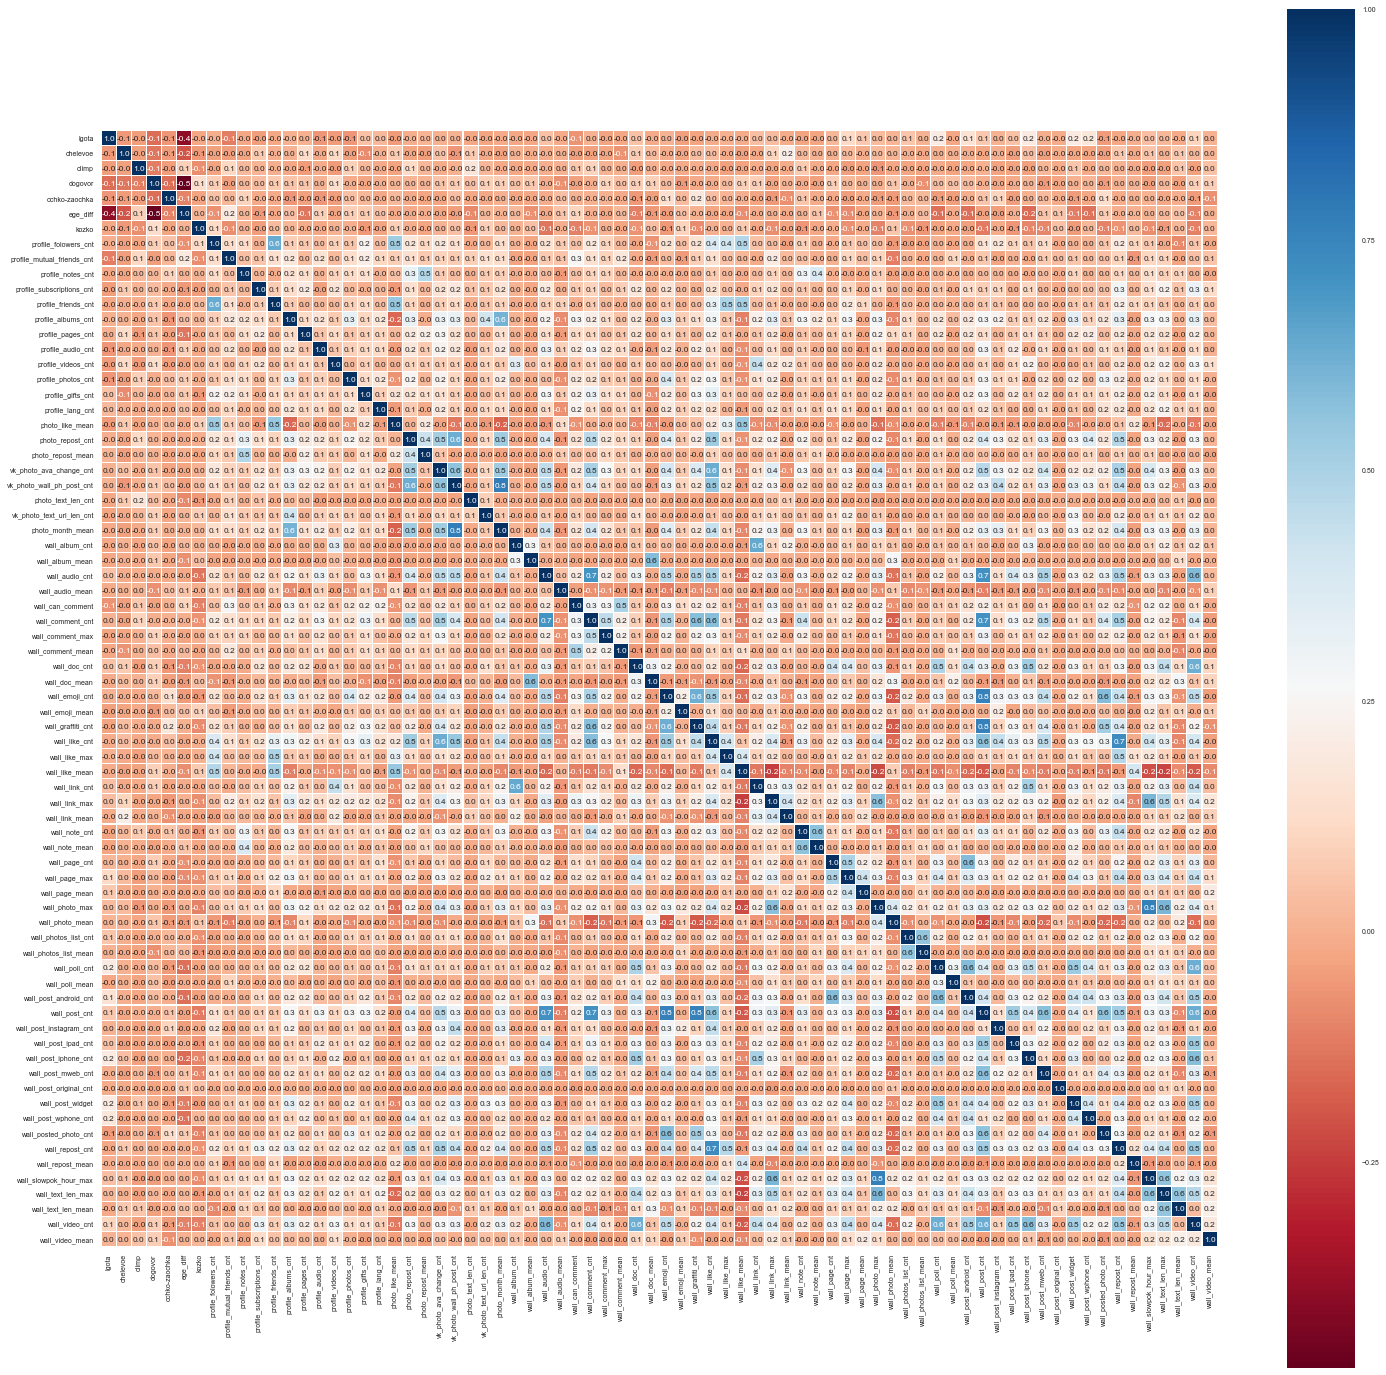

In [89]:
sns.set(font_scale=0.7)
plt.subplots(figsize=(25, 25))
sns.heatmap(total_df_3.drop(var_dl + ['uids', 'firstname', 'lastname', 'year','zima','leto',
                                      'kurs', 'prohodnoy','akadem','hodit_para','hodit_tusa',
                              'target_1', 'target_2', 'target_3', 'target_4'],axis=1).corr(), 
             square=True,annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Вроде бы всё нормально. Можно сохранять. 

In [90]:
# Сохраняем итог 
total_df_3.to_csv('data4_prof_ph_wl.csv', sep='\t', index=False, header=True)

# 5. Кластеры по пабликам 

Добавим к нашей большой табличке фичи, которые мы сварили по пабликам. 

In [91]:
df_pub_20 = pd.read_csv('vk_publ_clust_20_v11-01-18.csv', sep = '\t')
print('С удалёнными:', df_pub_20.shape)

# Убрали удалённые странички 
df_pub_20 = pd.merge(df_pub_20, df_pr[['uid']], on = 'uid', how='right')
print('Без удалённых:', df_pub_20.shape,'\n') 


df_pub_30 = pd.read_csv('vk_publ_clust_30_v11-01-18.csv', sep = '\t')
print('С удалёнными:', df_pub_30.shape)

# Убрали удалённые странички 
df_pub_30 = pd.merge(df_pub_30, df_pr[['uid']], on = 'uid', how='right')
print('Без удалённых:', df_pub_30.shape) 

С удалёнными: (673, 21)
Без удалённых: (674, 21) 

С удалёнными: (672, 32)
Без удалённых: (674, 32)


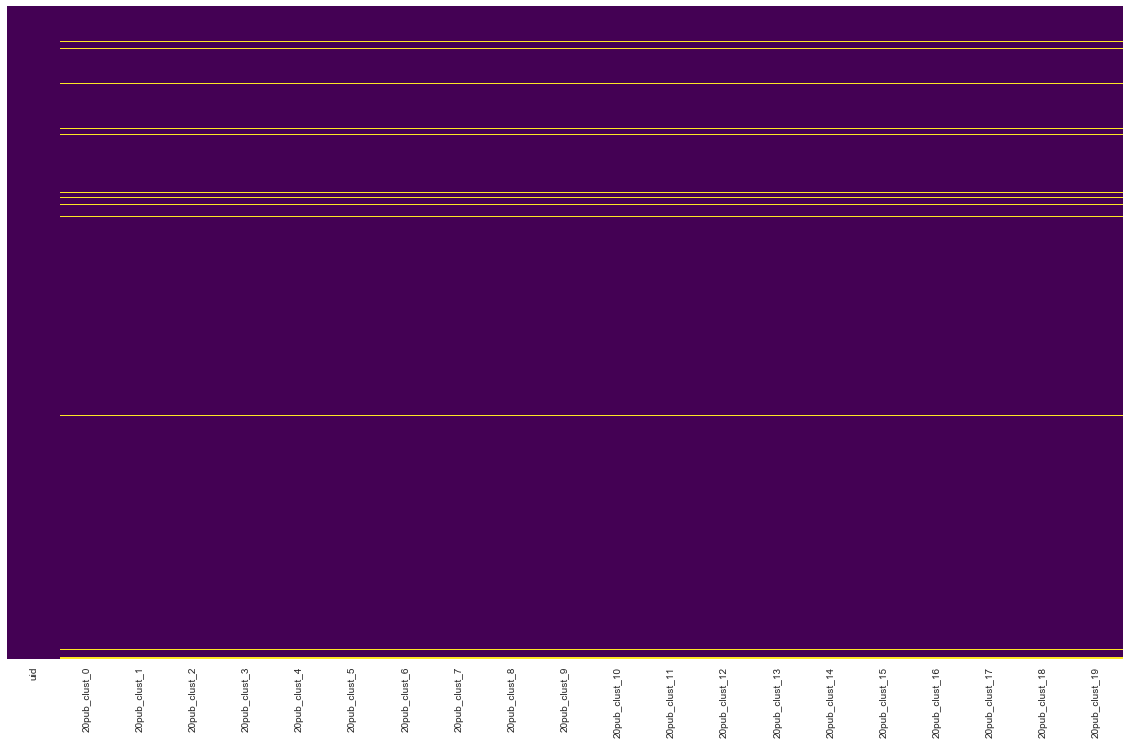

In [92]:
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df_pub_20.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [93]:
# Объединяем и все пропуски заливаем нулями
total_df_4 = pd.merge(total_df_3, df_pub_20.fillna(0), left_on = 'uids', right_on='uid', how='inner')
total_df_4.drop('uid', axis=1, inplace = True)
print(total_df_4.shape)

total_df_5 = pd.merge(total_df_4, df_pub_30.fillna(0), left_on = 'uids', right_on='uid', how='inner')
total_df_5.drop('uid', axis=1, inplace = True)
print(total_df_5.shape)

total_df_5.to_csv('data5_prof_ph_wl_pub.csv', sep='\t', index=False, header=True)

(418, 148)
(418, 179)


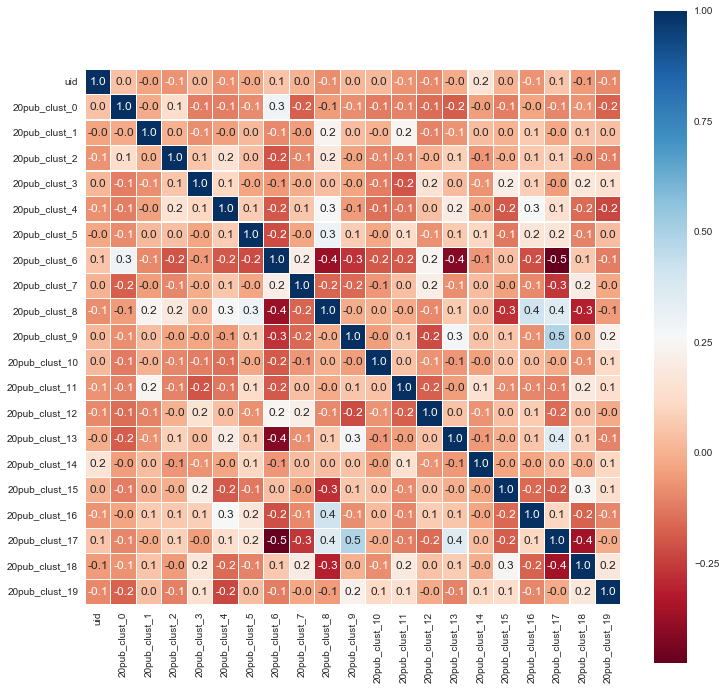

In [94]:
plt.subplots(figsize=(12, 12))
sns.heatmap(df_pub_20.fillna(0).corr(), square=True,annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

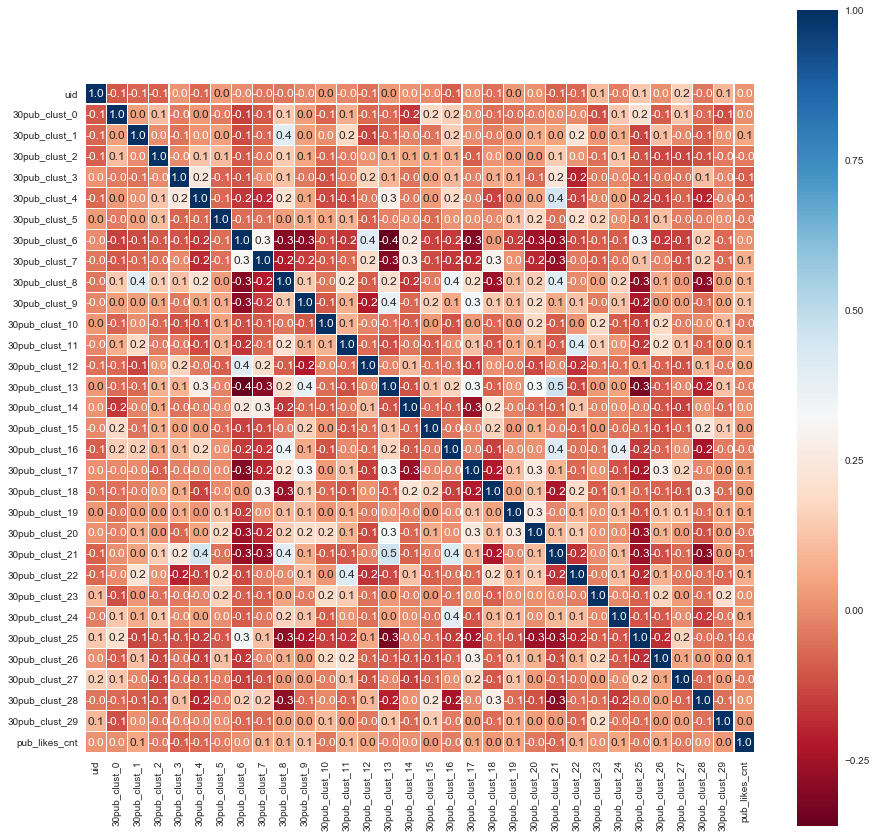

In [95]:
plt.subplots(figsize=(15, 15))
sns.heatmap(df_pub_30.fillna(0).corr(), square=True,annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

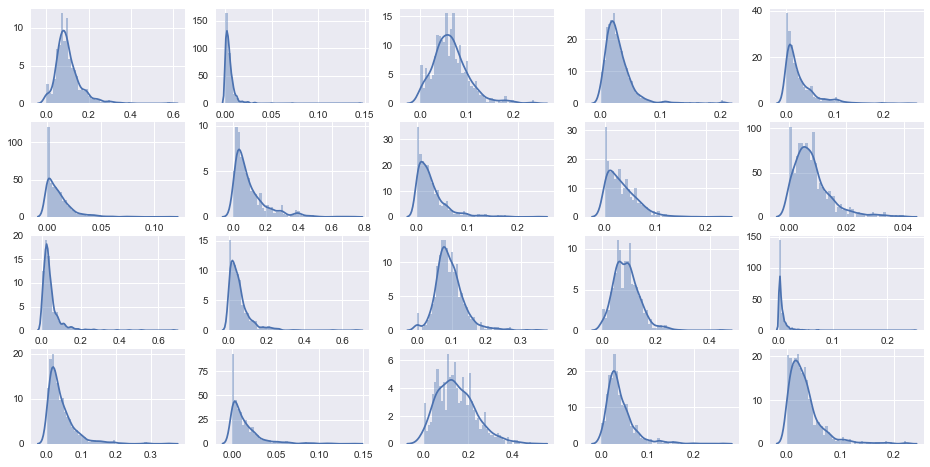

In [96]:
fig, axes = plt.subplots(4, 5, figsize=(16,8))
feat = ['BMI','Employment_Info_1','Medical_History_32']
for i in range(df_pub_20.drop('uid',axis=1).shape[1]):
    sns.distplot(df_pub_20.drop('uid',axis=1).fillna(0).iloc[:,i].get_values(), bins=50, ax=axes[i // 5, i % 5])

Построим scatterplot для пар кластеров. Для этого в seaborn есть функция pairplot. На диагоналях таблицы будут стоять оценки распределений признаков (гистограммы или восстановленные плотности, diag_kind="hist" или "kde"). Если указать параметр hue = дискретный целевой признак, то разные его значения будут отображаться разными цветами.

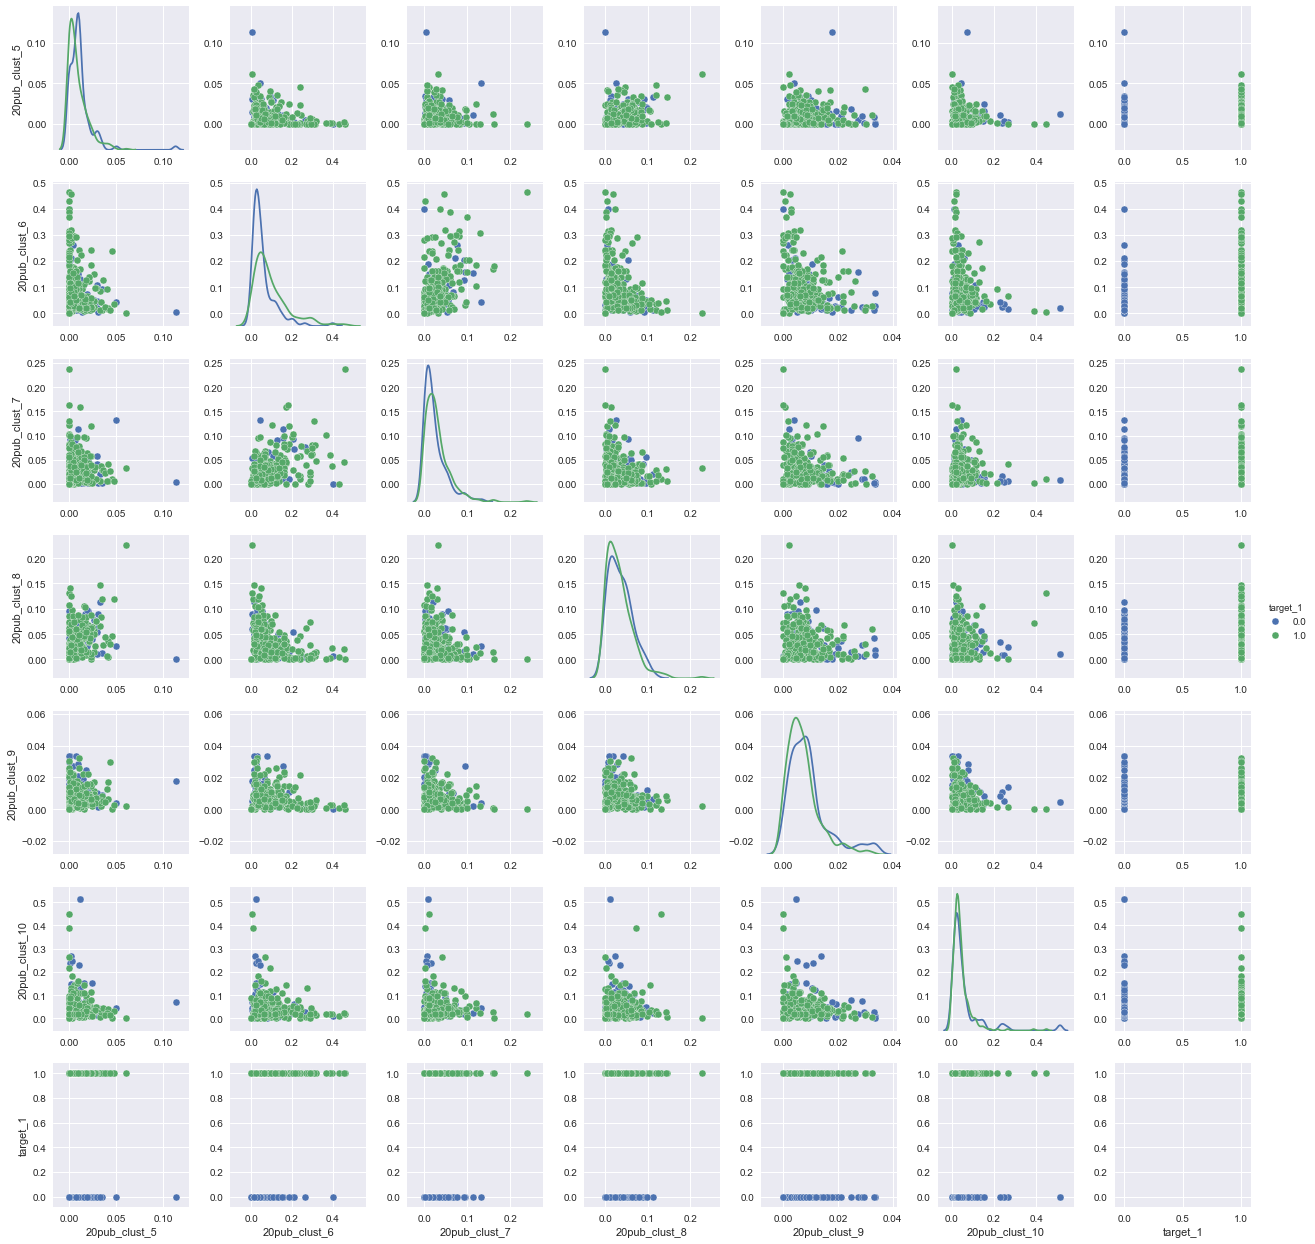

In [97]:
sns.pairplot(total_df_4[['20pub_clust_' + str(i) for i in range(5,11)] + ['target_1']] ,hue="target_1", diag_kind="kde")

На сегодня варки табличек хватит! Мы готовы к строительству модели. 

<img align="center" src="https://raw.githubusercontent.com/FUlyankin/Parsers/master/images%20/cats.jpg" height="1200" width="1200"> 